# **AI-Based Movement Tracking with Activity Classification**

This project uses the WISDM (Wireless Sensor Data Mining) dataset to classify physical activities based on accelerometer and gyroscope sensor data collected from smartphones.  
The primary objective is to implement machine learning and deep learning models to accurately classify activities such as walking, jogging, sitting, standing, climbing upstairs, and downstairs.

I explore model performance with and without class balancing (using class weights) to address class imbalance and improve overall classification accuracy.


In [1]:
%pip install pandas numpy requests tensorflow matplotlib imblearn keras --quiet
%pip install -U scikit-learn  --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import necessary libraries
import pandas as pd
import os
import zipfile
import requests
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

### **Dataset Overview**

The WISDM dataset contains time-series sensor data collected from accelerometers and gyroscopes at 20 Hz frequency.  
Each data instance is associated with:
- **User ID**
- **Activity label**
- **Timestamp**
- **Accelerometer X, Y, Z**
- **Gyroscope X, Y, Z**

I merged accelerometer and gyroscope data, handled missing values, and mapped numeric activity labels to meaningful category names.


###  **Downloading the WISDM Dataset**

In this step, I check whether the **WISDM Activity Recognition Dataset** is available locally.  
If it is not, I download it from the official source.

Specifically, the code does the following:
- I first **check** if the dataset zip file (`WISDM_ar_v1.1_raw.zip`) already exists in the working directory.
- If the file is **missing**, I **download** it from the provided URL using the `requests` library.
- If the file **already exists**, I simply **skip the download** to avoid unnecessary re-downloading and save time.

This approach ensures that I do not waste resources and that the dataset is ready for further processing without delay.


In [3]:
# ==========  Download the WISDM Dataset ==========
dataset_url = "https://www.cis.fordham.edu/wisdm/dataset/WISDM_ar_v1.1_raw.zip"
outer_zip = "WISDM_ar_v1.1_raw.zip"
outer_extract = "WISDM_raw_data"

# %%
def download_dataset(url, filename):
    if not os.path.exists(filename):
        print("Downloading dataset...")
        response = requests.get(url, stream=True)
        with open(filename, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)
        print("Download complete.")
    else:
        print("Dataset already downloaded.")

download_dataset(dataset_url, outer_zip)


Dataset already downloaded.


### **Extracting the Dataset Files**

After downloading the dataset, I proceed to extract the compressed files.

The process involves two stages:
- First, I **extract the outer ZIP file** (`WISDM_ar_v1.1_raw.zip`) to a specified directory.
- Then, I **extract an inner ZIP file** (`wisdm-dataset.zip`) found within the first extraction.

By organizing the extraction this way, I ensure that all raw data files are properly available for processing without manual intervention.

In [4]:
# ========== STEP 2: Extract the ZIPs ==========
# %%
def extract_zip(zip_path, extract_path):
    if not os.path.exists(extract_path):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Extracted to: {extract_path}")
    else:
        print(" Already extracted.")

def extract_inner_zip(inner_zip_path, extract_path):
    if not os.path.exists(extract_path):
        with zipfile.ZipFile(inner_zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Inner ZIP extracted to: {extract_path}")
    else:
        print("Inner ZIP already extracted.")

extract_zip(outer_zip, outer_extract)

inner_zip_path = os.path.join(outer_extract, "wisdm-dataset.zip")
inner_extract_path = os.path.join(outer_extract, "WISDM_dataset")
extract_inner_zip(inner_zip_path, inner_extract_path)

 Already extracted.
Inner ZIP already extracted.


## **Data Preprocessing**

- **Merged accelerometer and gyroscope data by timestamp and user**
- **Mapped activity codes to descriptive labels**
- **Handled missing values by filling gaps with the mean values**
- **Saved a clean, merged dataset**

This ensures a structured and clean input for training our classification models.


### **Loading Accelerometer and Gyroscope Sensor Data**

Now that the dataset is extracted, I load the **raw sensor data** from the extracted folders.

Here is how I do it:
- I define a function `load_sensor_data()` to read all `.txt` files from a specified folder.
- For each file:
  - I extract the **user session ID** from the filename.
  - I parse each line to extract the **activity**, **timestamp**, and **sensor readings** (`x`, `y`, `z`).
- I build a clean DataFrame where each row corresponds to a sensor reading at a specific time.

I load two types of sensor data separately:
- **Accelerometer data** (acceleration along x, y, z axes)
- **Gyroscope data** (angular velocity along x, y, z axes)

By doing this, I prepare structured datasets for both sensor modalities, which I can later merge and process together for activity recognition.

In [5]:
# %%
def load_sensor_data(sensor_path, sensor_type):
    all_data = []
    sensor_files = sorted(f for f in os.listdir(sensor_path) if f.endswith(".txt"))

    for file in sensor_files:
        file_path = os.path.join(sensor_path, file)
        session_id = int(file.split('_')[1])

        with open(file_path, 'r') as f:
            for line in f:
                try:
                    parts = line.strip().strip(';').split(',')
                    if len(parts) == 6:
                        _, activity, timestamp, x, y, z = parts
                        all_data.append([
                            session_id,
                            activity.strip(),
                            int(timestamp),
                            float(x),
                            float(y),
                            float(z)
                        ])
                except ValueError:
                    continue

    df = pd.DataFrame(all_data, columns=['user', 'activity', 'timestamp', f'{sensor_type}_x', f'{sensor_type}_y', f'{sensor_type}_z'])
    return df

# Load both accelerometer and gyroscope data
accel_folder = os.path.join(inner_extract_path, "wisdm-dataset", "raw", "phone", "accel")
gyro_folder = os.path.join(inner_extract_path, "wisdm-dataset", "raw", "phone", "gyro")

df_accel = load_sensor_data(accel_folder, "acc")
df_gyro = load_sensor_data(gyro_folder, "gyro")

# Display first few rows of both dataframes
print("Accelerometer data:")
print(df_accel.head())

print("\nGyroscope data:")
print(df_gyro.head())

Accelerometer data:
   user activity        timestamp     acc_x      acc_y     acc_z
0  1600        A  252207666810782 -0.364761   8.793503  1.055084
1  1600        A  252207717164786 -0.879730   9.768784  1.016998
2  1600        A  252207767518790  2.001495  11.109070  2.619156
3  1600        A  252207817872794  0.450623  12.651642  0.184555
4  1600        A  252207868226798 -2.164352  13.928436 -4.422485

Gyroscope data:
   user activity        timestamp    gyro_x    gyro_y    gyro_z
0  1600        A  252207918580802 -0.853210  0.297226  0.890182
1  1600        A  252207968934806 -0.875137  0.015472  0.162231
2  1600        A  252208019288809 -0.720169  0.388489 -0.284012
3  1600        A  252208069642813 -0.571640  1.227402 -0.241669
4  1600        A  252208119996817 -0.380493  1.202835 -0.213135


### **Preview of Loaded Sensor Data**

After loading the raw sensor files, I display the first few rows of the **Accelerometer** and **Gyroscope** datasets.

Each dataset contains:
- `user`: The session ID of the user
- `activity`: The activity code (currently still encoded as a letter)
- `timestamp`: The recorded time of each reading
- Sensor readings:
  - `acc_x`, `acc_y`, `acc_z` for accelerometer data
  - `gyro_x`, `gyro_y`, `gyro_z` for gyroscope data

**Observations:**

- The accelerometer records the **linear acceleration** along the x, y, and z axes.
- The gyroscope records the **angular velocity** along the x, y, and z axes.
- Both sensors use synchronized timestamps, which will allow me to later **merge** the two datasets if needed.
- The `activity` column is still in letter format (e.g., 'A'), so I will need to **decode** it into meaningful activity names in a future step.

At this stage, the sensor readings are successfully structured and ready for preprocessing.

In [6]:
# Re-sort both dataframes by 'timestamp'
df_accel = df_accel.sort_values(by='timestamp').reset_index(drop=True)
df_gyro = df_gyro.sort_values(by='timestamp').reset_index(drop=True)

# %%
# Increase tolerance to 30 seconds to allow a broader match between timestamps
df_merged = pd.merge_asof(
    df_accel,
    df_gyro,
    on='timestamp',
    by='user',
    direction='nearest',
    tolerance=30000000   
)

### **Synchronizing and Merging Sensor Data**

Since the accelerometer and gyroscope data were recorded independently, their timestamps are not perfectly aligned.  
To properly combine the two datasets, I perform the following steps:

- **Re-sorting**:  
  First, I sort both the accelerometer (`df_accel`) and gyroscope (`df_gyro`) dataframes by their `timestamp` in ascending order.  
  This is required because the merging function (`merge_asof`) expects the data to be sorted chronologically.

- **Merging**:  
  I use **`merge_asof()`** from pandas to perform a **nearest-neighbor join** based on timestamps and user ID.  
  - For each accelerometer reading, I find the closest gyroscope reading (for the same user).
  - I allow a maximum **tolerance of 30 seconds** (30,000,000 microseconds) between the two timestamps to still consider them a valid match.

This way, I create a **merged dataset** (`df_merged`) that combines both linear acceleration and angular velocity measurements for the same moment as closely as possible.

In [7]:
# Mapping activity codes to full activity labels
activity_map = {
    'A': 'walking', 'B': 'jogging', 'C': 'stairs', 'D': 'sitting', 'E': 'standing',
    'F': 'typing', 'G': 'teeth', 'H': 'soup', 'I': 'chips', 'J': 'pasta', 'K': 'drinking',
    'L': 'sandwich', 'M': 'kicking', 'O': 'catch', 'P': 'dribbling', 'Q': 'writing', 'R': 'clapping', 'S': 'folding'
}

# Map 'activity_x' (from accelerometer data) to full activity labels
df_merged['activity'] = df_merged['activity_x'].map(activity_map)

# Check the result of mapping
print("Mapped activity column:")
print(df_merged[['activity_x', 'activity']].head())


Mapped activity column:
  activity_x activity
0          O    catch
1          O    catch
2          O    catch
3          O    catch
4          O    catch


In [8]:
# Check and print missing values before filling
print("Missing values in the data before filling:")
missing_values_before = df_merged.isna().sum()
print(missing_values_before)

Missing values in the data before filling:
user              0
activity_x        0
timestamp         0
acc_x             0
acc_y             0
acc_z             0
activity_y    32785
gyro_x        32785
gyro_y        32785
gyro_z        32785
activity          0
dtype: int64


After merging the accelerometer and gyroscope datasets, I check for any **missing values** to ensure data quality.

Specifically:
- I use the `isna().sum()` function to **count the number of missing (NaN) values** in each column of the merged dataframe (`df_merged`).
- This helps me identify if any accelerometer readings failed to find a matching gyroscope reading within the allowed 30-second tolerance.

- Columns related to gyroscope data (`gyro_x`, `gyro_y`, `gyro_z`, and `activity_y`) have **32,785 missing values**.
- This suggests that for about 32,785 accelerometer samples, there was no corresponding gyroscope measurement within the tolerance window.

In [9]:
# Filling missing gyroscope data with the mean of each column
df_merged[['gyro_x', 'gyro_y', 'gyro_z']] = df_merged[['gyro_x', 'gyro_y', 'gyro_z']].fillna(df_merged[['gyro_x', 'gyro_y', 'gyro_z']].mean())
df_merged = df_merged.drop(columns=['activity_y'])

# Check and print missing values after filling
print("\nMissing values after filling:")
missing_values_after = df_merged.isna().sum()
print(missing_values_after)


Missing values after filling:
user          0
activity_x    0
timestamp     0
acc_x         0
acc_y         0
acc_z         0
gyro_x        0
gyro_y        0
gyro_z        0
activity      0
dtype: int64


### **Cleaning and Saving the Final Dataset**

Now that I have successfully merged and cleaned the sensor data,  
I save it into a new CSV file for easier access in the next stages of modeling.

Here is what I do in this step:
- I define a function `clean_and_save()`:
  - It **reorders the columns** into a logical structure:  
    `user`, `activity`, `timestamp`, accelerometer features (`acc_x`, `acc_y`, `acc_z`), and gyroscope features (`gyro_x`, `gyro_y`, `gyro_z`).
  - It **saves** the cleaned dataset into a CSV file called `wisdm_merged_accel_gyro_clean.csv`.
- I check if the critical `activity` column exists before saving to avoid mistakes.
- Finally, I return the cleaned DataFrame for future operations.


In [10]:
# cleaning and save data
def clean_and_save(df, output_csv="wisdm_merged_accel_gyro_clean.csv"):
    if 'activity' in df.columns:
        # Reorder columns for final save
        df = df[['user', 'activity', 'timestamp',
                 'acc_x', 'acc_y', 'acc_z',
                 'gyro_x', 'gyro_y', 'gyro_z']]
        
        # Save cleaned data to CSV
        df.to_csv(output_csv, index=False)
        print(f"Cleaned dataset saved as: {output_csv}")
    else:
        print("'activity' column missing. Skipping save.")
    return df

# Call clean_and_save with the merged DataFrame (df_merged)
df_merged = clean_and_save(df_merged)

Cleaned dataset saved as: wisdm_merged_accel_gyro_clean.csv


### **Normalizing Sensor Data**

After saving the cleaned dataset, I proceed to **normalize** the accelerometer and gyroscope readings.

Here's why and how I do it:
- **Why normalize?**
  - Sensor readings (`acc_x`, `acc_y`, `acc_z`, `gyro_x`, `gyro_y`, `gyro_z`) are on different numeric scales.
  - Neural networks train faster and perform better when input features are normalized to a standard range.
- **How normalize?**
  - I use the **`MinMaxScaler`** from Scikit-Learn to rescale all six sensor features to the range [0, 1].
  - Each set of accelerometer and gyroscope readings is normalized separately.

After applying normalization, I display the first few rows of the dataset to confirm that all feature values are within the expected range.

In [11]:
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv('wisdm_merged_accel_gyro_clean.csv')
# Initialize the scaler
scaler = MinMaxScaler()


# Normalize accelerometer (x, y, z) and gyroscope (gyro_x, gyro_y, gyro_z) data
df[['acc_x', 'acc_y', 'acc_z']] = scaler.fit_transform(df[['acc_x', 'acc_y', 'acc_z']])
df[['gyro_x', 'gyro_y', 'gyro_z']] = scaler.fit_transform(df[['gyro_x', 'gyro_y', 'gyro_z']])

# Display first few rows after scaling
df.head()

,user,activity,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
0,1611,catch,268102711042,0.526002,0.483822,0.545133,0.512795,0.525133,0.653482
1,1611,catch,268153065046,0.517372,0.485162,0.541802,0.512795,0.525133,0.653482
2,1611,catch,268203419049,0.511397,0.487817,0.533854,0.512795,0.525133,0.653482
3,1611,catch,268253773053,0.515254,0.484292,0.536274,0.512795,0.525133,0.653482
4,1611,catch,268304127057,0.529681,0.482478,0.543173,0.512795,0.525133,0.653482



### Accelerometer Data (`acc_x`, `acc_y`, `acc_z`)

These represent the **linear acceleration** in three dimensions (X, Y, Z axes).

- **`acc_x`**: Acceleration in the horizontal plane (**left-right**).
- **`acc_y`**: Acceleration in the vertical plane (**up-down**).
- **`acc_z`**: Acceleration along the depth axis (**forward-backward**).

**What it shows**: Movement, inclination, and orientation of the device (e.g., walking, sitting, or jumping).

### Gyroscope Data (`gyro_x`, `gyro_y`, `gyro_z`)

These represent the **angular velocity** (rate of rotation) around the three axes.

- **`gyro_x`**: Rotation around the x-axis (**pitch**).
- **`gyro_y`**: Rotation around the y-axis (**yaw**).
- **`gyro_z`**: Rotation around the z-axis (**roll**).

**What it shows**: How the device is rotating or changing its orientation in space (e.g., turning head or performing complex gestures like waving).


## **Data Balancing: Activity-Based Balancing**

The WISDM dataset is naturally imbalanced — some activities like **walking** and **jogging** have more data compared to activities like **sitting** or **downstairs**.

To address this:
- I computed the distribution of data points per activity.
- Applied **undersampling or oversampling** techniques to balance the number of samples for each activity.

This ensures that the model is not biased towards the majority activities and learns to classify each activity more equally.


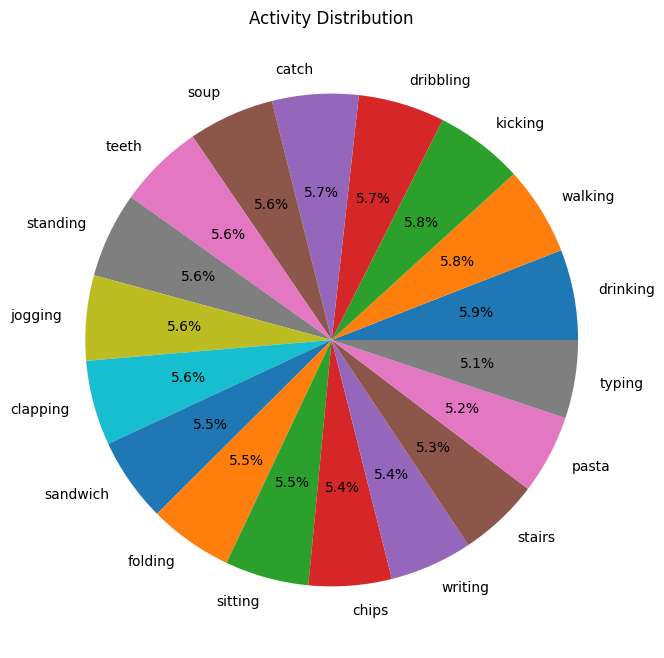

Activity class imbalance: Min count = 246356, Max count = 285190


In [12]:
# Visualize the activity distribution (pie chart)
activity_counts = df_merged['activity'].value_counts()
activity_counts.plot(kind='pie', autopct='%1.1f%%', figsize=(8, 8), title='Activity Distribution')
plt.ylabel('')  # Hide the ylabel for clarity
plt.show()

# Check for class imbalance
min_count = activity_counts.min()
max_count = activity_counts.max()
print(f"Activity class imbalance: Min count = {min_count}, Max count = {max_count}")

This means there is some imbalance in the dataset. The difference between the least and most frequent activities is significant, with some activities having around 40,000 fewer samples than others.

### **Preparing Features, Splitting, and Balancing the Dataset**

At this stage, I prepare the dataset for model training by following these steps:


**Preparing Features and Labels**
- I extract the sensor features (`acc_x`, `acc_y`, `acc_z`, `gyro_x`, `gyro_y`, `gyro_z`) as my input features (**X**).
- The corresponding **activity labels** are extracted as the target variable (**y**).

**Splitting into Training and Testing Sets**
- I split the data into **80% training** and **20% testing** sets using `train_test_split`.
- I set a `random_state` for reproducibility.

**Encoding Labels**
- Since the activity labels are currently strings (like 'Walking', 'Jogging'), I apply **Label Encoding** using `LabelEncoder`:
  - I fit and transform the training labels.
  - I transform the test labels accordingly.

**Creating a DataFrame for Training Data**
- I combine the **training features** and **encoded labels** into a single DataFrame (`df_train`) to easily perform balancing.

**Finding the Smallest Class Size**
- I calculate the number of samples in the **smallest activity class**.
- This is important to ensure that my training set is balanced and avoids class imbalance.

**Downsampling to Balance Classes**
- I perform **downsampling** by randomly selecting samples from each class to match the smallest class size.
- This ensures that all classes are represented equally, preventing the model from being biased toward more frequent activities.

**Separating Features and Labels After Balancing**
- I split the balanced dataset back into separate features (**X_train_balanced**) and labels (**y_train_balanced**).

**Verifying Balanced Class Distribution**
- I print the new class distribution to confirm that all classes have an equal number of samples after balancing.

**Reshaping Data for LSTM/GRU Model Input**
- Since LSTM and GRU models expect **3D input** (samples, timesteps, features), I reshape:
  - Training set (`X_train_reshaped`)
  - Testing set (`X_test_reshaped`)

Now the data is fully ready for sequential models like LSTM, GRU, or 3D CNNs.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import pandas as pd
import numpy as np

# STEP 1: Prepare features and labels
X = df_merged[['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']].values
y = df_merged['activity'].values

# STEP 2: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# STEP 3: Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# STEP 4: Combine training features and labels into a DataFrame
df_train = pd.DataFrame(X_train)
df_train["label"] = y_train_encoded

# STEP 5: Find the smallest class size
min_count = min(Counter(y_train_encoded).values())
print(f"Smallest class count: {min_count}")

# STEP 6: Downsample each class to the smallest class size
balanced_df = df_train.groupby("label", group_keys=False).apply(
    lambda x: x.sample(min_count, random_state=42)
).reset_index(drop=True)

# STEP 7: Separate features and labels
X_train_balanced = balanced_df.drop("label", axis=1).values
y_train_balanced = balanced_df["label"].values

# STEP 8:  Check new balanced class distribution
print("Balanced training set class distribution:", Counter(y_train_balanced))

# STEP 9: Reshape for LSTM or GRU model input
X_train_reshaped = X_train_balanced.reshape((X_train_balanced.shape[0], X_train_balanced.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))


Smallest class count: 196746


C:\Users\chath\AppData\Local\Temp\ipykernel_10820\1561499040.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df_train.groupby("label", group_keys=False).apply(


Balanced training set class distribution: Counter({np.int64(0): 196746, np.int64(1): 196746, np.int64(2): 196746, np.int64(3): 196746, np.int64(4): 196746, np.int64(5): 196746, np.int64(6): 196746, np.int64(7): 196746, np.int64(8): 196746, np.int64(9): 196746, np.int64(10): 196746, np.int64(11): 196746, np.int64(12): 196746, np.int64(13): 196746, np.int64(14): 196746, np.int64(15): 196746, np.int64(16): 196746, np.int64(17): 196746})


### **Visualizing Class Distributions**

To ensure the dataset is properly prepared, I visualize the distribution of activity classes at different stages.

I define a helper function `print_class_distribution()` that:
- Prints the number of samples for each activity class.
- Optionally decodes numerical labels back to their original activity names using the `LabelEncoder`.
- Provides a clear, easy-to-read summary with titles for each distribution.

I use this function to check:
- **Original Class Distribution**: Before any splitting or balancing.
- **Training Set Distribution**: After splitting into training data.
- **Testing Set Distribution**: After splitting into testing data.
- **Balanced Training Set Distribution**: After applying downsampling to create a balanced training set.


In [14]:

def print_class_distribution(counter, label_encoder=None, title="Class Distribution"):
    print(f"\n {title}:")
    print("-" * 60)
    for k, v in counter.items():
        label = label_encoder.inverse_transform([k])[0] if label_encoder else k
        print(f"{label:<12}: {v}", end=" | ")
    print("\n" + "-" * 60 + "\n")

# Example usage:
from collections import Counter

print_class_distribution(Counter(label_encoder.transform(y)), label_encoder, "Original class distribution")
print_class_distribution(Counter(y_train_encoded), label_encoder, "Train class distribution")
print_class_distribution(Counter(y_test_encoded), label_encoder, "Test class distribution")
print_class_distribution(Counter(y_train_balanced), label_encoder, "Balanced Train class distribution")



 Original class distribution:
------------------------------------------------------------
catch       : 272219 | sitting     : 264592 | standing    : 269604 | kicking     : 278766 | clapping    : 268065 | dribbling   : 272730 | writing     : 260497 | typing      : 246356 | soup        : 270756 | teeth       : 269609 | folding     : 265214 | pasta       : 249793 | sandwich    : 265781 | stairs      : 255645 | drinking    : 285190 | jogging     : 268409 | chips       : 261360 | walking     : 279817 | 
------------------------------------------------------------


 Train class distribution:
------------------------------------------------------------
typing      : 196746 | writing     : 208374 | sandwich    : 212696 | teeth       : 215600 | jogging     : 214756 | walking     : 223831 | drinking    : 228193 | sitting     : 211478 | folding     : 211851 | soup        : 216845 | catch       : 218018 | kicking     : 223279 | clapping    : 214447 | pasta       : 199783 | dribbling   : 218416

### **Plotting Balanced Class Distribution**

After confirming the balanced class counts numerically,  
I also visualize the **class distribution** using a bar chart to provide a clearer, graphical view.

Here’s what I do:
- I calculate the number of samples for each activity in the balanced training dataset (`y_train_balanced`).
- I decode the integer labels back to their original activity names using the `LabelEncoder`.
- I plot a **bar graph** showing the number of samples for each activity.

In the plot:
- The x-axis shows the different physical activities (e.g., Walking, Jogging, Sitting).
- The y-axis shows the number of samples for each activity after balancing.
- I rotate the x-axis labels for better readability.

This graphical check helps me visually confirm that:
- All activity classes are now **equally represented**.
- There is **no class imbalance** left in the training data, which is crucial for fair model learning.

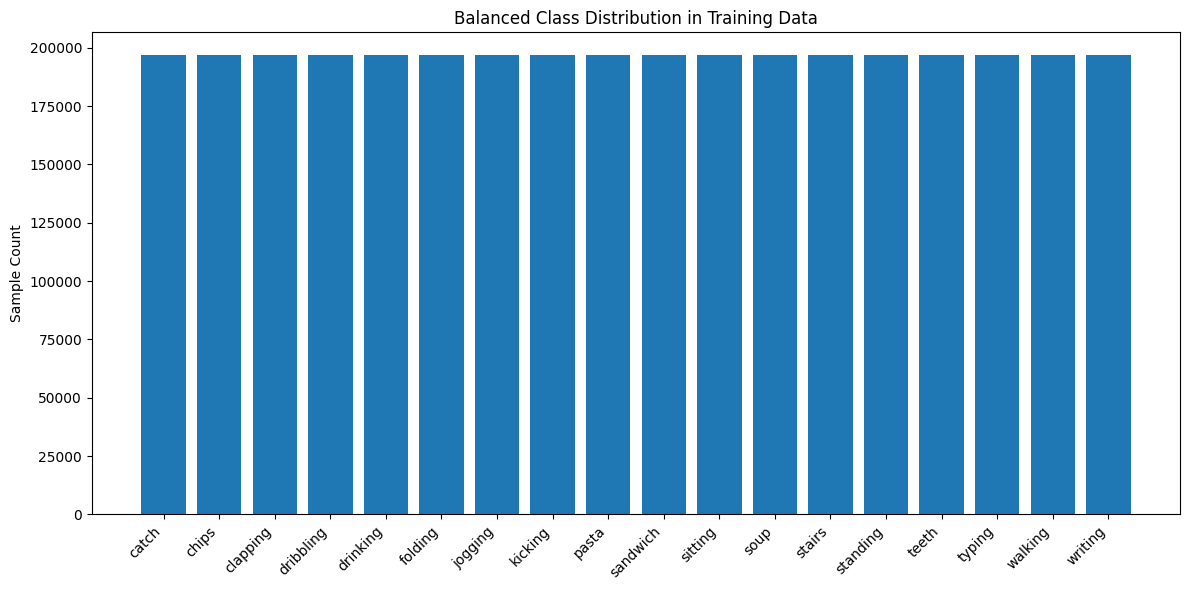

In [15]:
import matplotlib.pyplot as plt
from collections import Counter  

# Calculate balanced class distribution
balanced_counts = Counter(y_train_balanced)

# Plot class distribution
labels = [label_encoder.inverse_transform([i])[0] for i in balanced_counts.keys()]
counts = list(balanced_counts.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(rotation=45, ha='right')
plt.title("Balanced Class Distribution in Training Data")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

### **Saving the Balanced Training Dataset**

After balancing the class distributions,  
I save the final balanced training dataset into a new CSV file for easy access in the future.

Here’s what I do:
- I create a new DataFrame `df_balanced` combining:
  - The balanced sensor features (`acc_x`, `acc_y`, `acc_z`, `gyro_x`, `gyro_y`, `gyro_z`)
  - The corresponding **balanced labels** (`label`)
- I save this DataFrame to a file named **`balanced_training_data.csv`** without including the index column.
- I print a confirmation message after saving.

 By doing this, I ensure that:
- I can reload the **balanced dataset** anytime later without having to re-run the preprocessing steps.
- This also improves reproducibility and workflow efficiency.

In [16]:
# Save features and labels together
df_balanced = pd.DataFrame(X_train_balanced, columns=['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z'])
df_balanced['label'] = y_train_balanced

# Save to CSV
df_balanced.to_csv('balanced_training_data.csv', index=False)
print("Balanced training data saved to 'balanced_training_data.csv'")


Balanced training data saved to 'balanced_training_data.csv'


In [17]:
df_balanced = pd.read_csv('balanced_training_data.csv')
X_train_balanced = df_balanced.drop('label', axis=1).values
y_train_balanced = df_balanced['label'].values

### **User-Based Balancing**

Different users may have unequal amounts of data in the dataset, which can bias the model toward dominant users.

To handle this:
- I analysed the distribution of activity data across different users.
- Balanced the dataset by ensuring each user contributes a comparable number of data points.

This step improves the model's **generalisation** to unseen users and avoids overfitting to specific movement patterns.


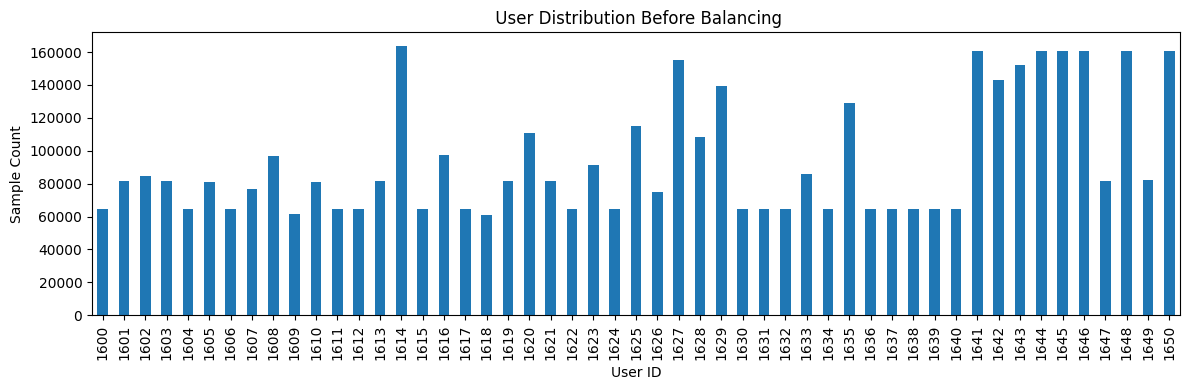

Smallest user sample count: 60771
User-level balanced dataset created.


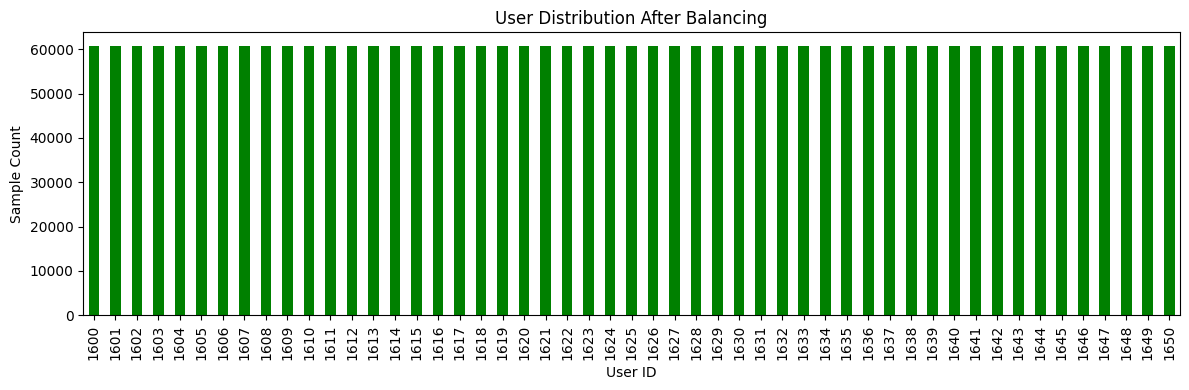

User Distribution Stats (after balancing):
user
1600    60771
1601    60771
1602    60771
1603    60771
1604    60771
1605    60771
1606    60771
1607    60771
1608    60771
1609    60771
1610    60771
1611    60771
1612    60771
1613    60771
1614    60771
1615    60771
1616    60771
1617    60771
1618    60771
1619    60771
1620    60771
1621    60771
1622    60771
1623    60771
1624    60771
1625    60771
1626    60771
1627    60771
1628    60771
1629    60771
1630    60771
1631    60771
1632    60771
1633    60771
1634    60771
1635    60771
1636    60771
1637    60771
1638    60771
1639    60771
1640    60771
1641    60771
1642    60771
1643    60771
1644    60771
1645    60771
1646    60771
1647    60771
1648    60771
1649    60771
1650    60771
Name: count, dtype: int64
User-balanced dataset saved to 'balanced_training_data.csv'


In [18]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Check if 'user' column exists
assert 'user' in df_merged.columns

# Count samples per user before balancing
user_counts_before = df_merged['user'].value_counts().sort_index()

# Visualize user distribution before balancing
plt.figure(figsize=(12, 4))
user_counts_before.plot(kind='bar')
plt.title(" User Distribution Before Balancing")
plt.xlabel("User ID")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

# Balance users by downsampling to the minimum user sample count
min_user_count = user_counts_before.min()
print(f"Smallest user sample count: {min_user_count}")

# Cleaned version 
df_user_balanced = pd.concat([
    group.sample(min_user_count, random_state=42)
    for _, group in df_merged.groupby("user")
], ignore_index=True)

print("User-level balanced dataset created.")

# Check and visualize distribution after balancing
user_counts_after = df_user_balanced['user'].value_counts().sort_index()

plt.figure(figsize=(12, 4))
user_counts_after.plot(kind='bar', color='green')
plt.title("User Distribution After Balancing")
plt.xlabel("User ID")
plt.ylabel("Sample Count")
plt.tight_layout()
plt.show()

# Print user distribution stats
print("User Distribution Stats (after balancing):")
print(user_counts_after)

# Save user-balanced dataset to the same CSV file
df_user_balanced.to_csv("balanced_training_data.csv", index=False)
print("User-balanced dataset saved to 'balanced_training_data.csv'")


##### **Visualisation: Before and After Data Balancing**

To verify the effectiveness of our balancing steps:
- Plotted **activity distribution before and after balancing**
- Plotted **user-wise data distribution**

This confirms that both activity-based and user-based balancing have been successfully applied, preparing the dataset for fair model training.

## **Feature Normalisation**

Sensor data collected from accelerometers and gyroscopes can have varying scales and ranges, which may negatively affect model performance.

To standardise the data:
- **Applied feature normalisation (StandardScaler or MinMaxScaler)** to scale all input features to a similar range.
- This helps in accelerating convergence and improves the stability of gradient-based learning algorithms.

Feature normalisation ensures that each feature contributes equally to the learning process.

In [19]:
from sklearn.preprocessing import MinMaxScaler

feature_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

scaler = MinMaxScaler()
df_user_balanced[feature_columns] = scaler.fit_transform(df_user_balanced[feature_columns])

print(" Min-Max Normalization complete.")

df_user_balanced.to_csv("balanced_training_data.csv", index=False)
print(" Normalized and balanced data saved to 'balanced_training_data.csv'")


 Min-Max Normalization complete.
 Normalized and balanced data saved to 'balanced_training_data.csv'


In [20]:
import pandas as pd

# Load the final balanced + normalized dataset
df = pd.read_csv("balanced_training_data.csv")

# Define feature and label columns
feature_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']
X = df[feature_columns].values
y = df['activity'].values  

## **Sliding Window Segmentation**

To prepare the time-series sensor data for model training, we apply a **sliding window segmentation technique**. 

#### Why Sliding Windows?
Since the WISDM dataset contains continuous accelerometer and gyroscope data streams, it's essential to split them into smaller, manageable, and meaningful segments (windows) to capture patterns over time.

#### How It Works:
- **Window Size:** 50 time steps  
- **Step Size:** 25 time steps (50% overlap between windows)  
- **Features Used:** Accelerometer (`acc_x`, `acc_y`, `acc_z`) and Gyroscope (`gyro_x`, `gyro_y`, `gyro_z`) data.

#### Label Assignment:
- For each window, the activity label is assigned based on **majority voting** — the most frequently occurring activity within that window.

#### Code Summary:
- The `create_windows` function:
  - Segments data per user.
  - Creates overlapping windows.
  - Collects sensor values.
  - Assigns the most common activity label to each window.

This step converts the continuous sensor stream into fixed-length windows, making it suitable for feeding into sequential deep learning models like LSTMs or GRUs.



In [21]:
import numpy as np
from collections import Counter

# Parameters
window_size = 50  # number of time steps in each window
step_size = 25    # step between windows (50% overlap)

# List of sensor columns
feature_columns = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

# Function to create sliding windows
def create_windows(df, window_size, step_size):
    X = []
    y = []
    user_ids = []
    
    for user in df['user'].unique():
        user_data = df[df['user'] == user]
        
        for start in range(0, len(user_data) - window_size, step_size):
            end = start + window_size
            window = user_data.iloc[start:end]
            
            # Collect features
            X.append(window[feature_columns].values)
            
            # Assign label based on majority voting
            labels = window['activity'].values
            most_common_label = Counter(labels).most_common(1)[0][0]
            y.append(most_common_label)
            
            # Track user ID (optional)
            user_ids.append(user)

    return np.array(X), np.array(y), np.array(user_ids)

# Apply windowing
X, y, user_ids = create_windows(df_merged, window_size, step_size)

print(f"Windowed data shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Windowed data shape: (192100, 50, 6)
Labels shape: (192100,)


After applying the sliding window segmentation:

- `X` shape: **(192,100, 50, 6)**  
  → 192,100 windows, each containing 50 time steps, and 6 sensor features (3 accelerometer + 3 gyroscope).
  
- `y` shape: **(192,100,)**  
  → 192,100 activity labels corresponding to each window.

- `user_ids`: User IDs mapped to each window (optional tracking)

This windowed dataset is now ready for model training.


##  **Label Encoding, One-Hot Conversion, and Data Splitting**

In this section, I prepare the activity labels and split the dataset into training and testing sets.

#### Label Encoding:
Since the activity labels are text (e.g., "walking", "jogging"), we first convert them into integer values using `LabelEncoder`.  
For example:
- `walking` → 16  
- `jogging` → 6

#### One-Hot Encoding:
The encoded integer labels are then converted into **one-hot encoded vectors** using `to_categorical`, which is suitable for multi-class classification.  
For 18 activity classes, each label is represented as a vector of length 18, where only the index corresponding to the activity class is `1`, and all others are `0`.

#### 🔹 Train-Test Split:
The dataset is split into:
- **80% Training Set**  
- **20% Testing Set**

Using `train_test_split` with:
- `random_state=42` to ensure reproducibility  
- `stratify=y_encoded` to maintain class balance in both sets

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Encode labels (text → integers)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Convert labels to one-hot encoding (for classification)
y_categorical = to_categorical(y_encoded)

# Split into training and test sets (80% train / 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

# Optional: View the label encoding mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)


Training set shape: (153680, 50, 6) (153680, 18)
Test set shape: (38420, 50, 6) (38420, 18)
Label mapping: {np.str_('catch'): np.int64(0), np.str_('chips'): np.int64(1), np.str_('clapping'): np.int64(2), np.str_('dribbling'): np.int64(3), np.str_('drinking'): np.int64(4), np.str_('folding'): np.int64(5), np.str_('jogging'): np.int64(6), np.str_('kicking'): np.int64(7), np.str_('pasta'): np.int64(8), np.str_('sandwich'): np.int64(9), np.str_('sitting'): np.int64(10), np.str_('soup'): np.int64(11), np.str_('stairs'): np.int64(12), np.str_('standing'): np.int64(13), np.str_('teeth'): np.int64(14), np.str_('typing'): np.int64(15), np.str_('walking'): np.int64(16), np.str_('writing'): np.int64(17)}


##### Training and Testing Set Shapes:
- **Training Set**:  
  - `X_train`: (153,680, 50, 6) → 153,680 windows, each with 50 time steps and 6 features  
  - `y_train`: (153,680, 18) → One-hot encoded activity labels for 18 different activity classes

- **Testing Set**:  
  - `X_test`: (38,420, 50, 6)  
  - `y_test`: (38,420, 18)

##### Activity Label Mapping:
The original string activity labels are mapped to integer values as follows:

| Activity      | Label |
|:--------------|:------|
| catch         | 0 |
| chips         | 1 |
| clapping      | 2 |
| dribbling     | 3 |
| drinking      | 4 |
| folding       | 5 |
| jogging       | 6 |
| kicking       | 7 |
| pasta         | 8 |
| sandwich      | 9 |
| sitting       | 10 |
| soup          | 11 |
| stairs        | 12 |
| standing      | 13 |
| teeth         | 14 |
| typing        | 15 |
| walking       | 16 |
| writing       | 17 |

This encoding ensures that the labels are in a numerical format for multi-class classification with deep learning models.

#### **Activity Time-Series Plot (for a Specific User)**

This visualization helps us **understand how a user's activities are distributed over time** based on the sensor data.

##### Purpose:
- Visualize **how activities change sequentially** for a specific user.
- Detect patterns or transitions between activities.
- Identify continuous periods of the same activity or activity switching behavior.

##### How It Works:
- Select a specific user from the dataset.
- Extract the sequence of activity labels recorded over time for that user.
- Plot the activity labels against the corresponding time indices (or sample numbers).

##### What the Plot Shows:
- **X-axis**: Time (or data sample index)
- **Y-axis**: Activity labels (converted to readable activity names)
- Each point (or step) represents the activity performed at that moment.
- Different colors or levels represent different activities.

##### Why It’s Valuable:
- A simple but powerful way to visually **track the flow of activities** for an individual.
- Useful for debugging the dataset and ensuring labels are properly assigned over time.
- Can reveal unique behavior patterns for users — such as long sedentary periods, bursts of jogging, etc.


In [23]:
# 
import plotly.graph_objects as go

# Create an interactive time-series plot with a dropdown for user selection

# Define the figure with initial plot (empty)
fig = go.Figure()

# Loop through all unique user IDs and add a trace for each
unique_users = df_merged['user'].unique()

# Add traces for each user
for user_id in unique_users:
    user_data = df_merged[df_merged['user'] == user_id]
    fig.add_trace(go.Scatter(
        x=user_data['timestamp'], 
        y=user_data['activity'], 
        mode='lines',
        name=f"User {user_id}"
    ))

# Add dropdown to select user
fig.update_layout(
    updatemenus=[{
        'buttons': [
            {'label': f'All Users', 'method': 'update', 'args': [{'visible': [True]*len(unique_users)}, {'title': 'Activity Time Series for All Users'}]},
            *[
                {'label': f'User {user_id}', 'method': 'update', 
                 'args': [{'visible': [user_id == unique_users[i] for i in range(len(unique_users))]}, 
                          {'title': f'Activity Time Series for User {user_id}'}]}
                for user_id in unique_users
            ]
        ],
        'direction': 'down',
        'showactive': True,
        'active': 0,
    }],
    title='Activity Time Series for All Users',
    xaxis_title='Timestamp (ms)',
    yaxis_title='Activity'
)

import plotly.io as pio
pio.renderers.default = "browser" 
fig.show()

### **Data Reshaping for Model Input**

Before training the model, it’s important to **reshape the input data into the correct format** expected by sequential models like LSTM or GRU.

##### Purpose:
- Convert the windowed training and test data into a **3D shape** suitable for time-series models:
  - `(samples, window_size, number_of_features)`

##### How It Works:
- Check if the total number of elements in `X_train` and `X_test` can be reshaped cleanly into `(number of windows, window_size, number of features)`.
- If compatible:
  - Reshape `X_train` and `X_test` into the target shape.
- If not:
  - Raise an error to notify that the data shape is incompatible — preventing silent misalignments in model training.

##### Final Shape:
- **X_train shape**: `(number of training samples, window_size, number of features)`
- **X_test shape**: `(number of test samples, window_size, number of features)`

In [24]:
# Ensure the array size matches the target shape before reshaping
if X_train.size % (window_size * len(feature_columns)) == 0:
	X_train_reshaped = X_train.reshape((-1, window_size, len(feature_columns)))
else:
	raise ValueError("X_train size is not compatible with the target shape.")

if X_test.size % (window_size * len(feature_columns)) == 0:
	X_test_reshaped = X_test.reshape((-1, window_size, len(feature_columns)))
else:
	raise ValueError("X_test size is not compatible with the target shape.")

##  **Model Implementation**

I implemented and trained the following deep learning models to classify physical activities:

- **LSTM (Long Short-Term Memory)**
- **GRU (Gated Recurrent Unit)**
- **3D-CNN (Three-dimensional Convolutional Neural Network)**

I selected these architectures due to their strengths in handling sequential and temporal data.


### **First Model - LSTM Model**
In this section, we build a **Sequential Long Short-Term Memory (LSTM) model** designed to classify activities based on time-series sensor data.

##### Model Architecture:
- **Input Shape:**  
  `(window_size, number of features)`  
  Example: `(50, 6)` where 50 is the number of timesteps and 6 is the number of sensor signals per timestep.

- **Layers:**
  1. **LSTM (128 units)**  
     - Returns sequences for the next LSTM layer.
  2. **Dropout (0.2)**  
     - Prevents overfitting by randomly dropping 20% of units.
  3. **LSTM (64 units)**  
     - Outputs a vector (return_sequences=False).
  4. **Dropout (0.2)**
  5. **Dense (64 units, ReLU activation)**
  6. **Dropout (0.2)**
  7. **Dense (num_classes, Softmax activation)**  
     - Outputs class probabilities.

##### Compilation:
- **Optimizer:** `Adam`
- **Loss Function:** `Categorical Crossentropy`  
  (suitable for multi-class classification problems with one-hot encoded labels)
- **Metrics:** `Accuracy`

After defining the model, `model.summary()` is called to display a structured summary of the layers, output shapes, and number of parameters.


In [25]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define the LSTM model
def create_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = (window_size, len(feature_columns))  # window_size and feature_columns are already defined
num_classes = len(label_mapping)  # label_mapping is already defined

# Create the model
model = create_lstm_model(input_shape, num_classes)

# Display the model summary
model.summary()

c:\Users\chath\Desktop\T1_2025\SIT378\SIT378\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 128)        │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,858 (483.82 KB)

 Trainable params: 123,858 (483.82 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
%pip install keras -- quiet

from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=5,                   # Stop after 5 epochs with no improvement
    restore_best_weights=True     # Restore the best weights seen during training
)

# Define learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.5,                   # Reduce learning rate by half if no improvement
    patience=3,                   # Number of epochs to wait before reducing LR
    verbose=1                     # Print updates
)

# Train the model
history = model.fit(
    X_train_reshaped, 
    y_train, 
    validation_data=(X_test_reshaped, y_test), 
    epochs=20,                    # Start with 20 epochs
    batch_size=128,               # Increased batch size for faster training
    callbacks=[early_stopping, reduce_lr],  # Add both callbacks
    verbose=2                     # Show per-epoch updates
)

# Display training history
print("Training complete.")

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for quiet


Epoch 1/20
1201/1201 - 243s - 203ms/step - accuracy: 0.2877 - loss: 2.0682 - val_accuracy: 0.3972 - val_loss: 1.7324 - learning_rate: 1.0000e-03
Epoch 2/20
1201/1201 - 236s - 196ms/step - accuracy: 0.4156 - loss: 1.6799 - val_accuracy: 0.4800 - val_loss: 1.4929 - learning_rate: 1.0000e-03
Epoch 3/20
1201/1201 - 206s - 171ms/step - accuracy: 0.4924 - loss: 1.4704 - val_accuracy: 0.5570 - val_loss: 1.2942 - learning_rate: 1.0000e-03
Epoch 4/20
1201/1201 - 199s - 166ms/step - accuracy: 0.5622 - loss: 1.2843 - val_accuracy: 0.6204 - val_loss: 1.1144 - learning_rate: 1.0000e-03
Epoch 5/20
1201/1201 - 197s - 164ms/step - accuracy: 0.6058 - loss: 1.1652 - val_accuracy: 0.6590 - val_loss: 0.9943 - learning_rate: 1.0000e-03
Epoch 6/20
1201/1201 - 199s - 166ms/step - accuracy: 0.6527 - loss: 1.0425 - val_accuracy: 0.7002 - val_loss: 0.8932 - learning_rate: 1.0000e-03
Epoch 7/20
1201/1201 - 199s - 166ms/step - accuracy: 0.6836 - loss: 0.9617 - val_accuracy: 0.7191 - val_loss: 0.8568 - learning_ra

In [27]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test accuracy: {test_accuracy:.4f}')

1201/1201 ━━━━━━━━━━━━━━━━━━━━ 35s 29ms/step - accuracy: 0.8196 - loss: 0.5676
Test accuracy: 0.8188


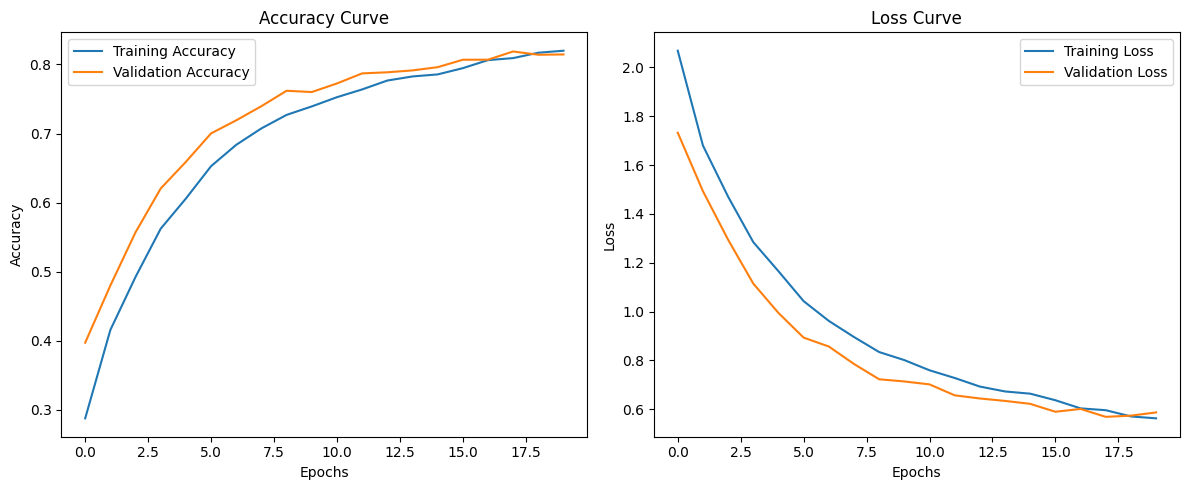

In [28]:
# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sklearn.metrics import classification_report
import numpy as np

y_test_classes = np.argmax(y_test, axis=1)

# Predict classes on test set
y_pred_probs = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Assuming your labels are categorical integers like 0, 1, 2, 3, 4, 5...
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=label_encoder.classes_))


1201/1201 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step
Classification Report:
              precision    recall  f1-score   support

       catch       0.74      0.67      0.71      2177
       chips       0.81      0.79      0.80      2092
    clapping       0.83      0.81      0.82      2145
   dribbling       0.72      0.81      0.76      2180
    drinking       0.83      0.68      0.74      2282
     folding       0.73      0.74      0.73      2120
     jogging       0.98      0.97      0.98      2145
     kicking       0.73      0.83      0.78      2229
       pasta       0.74      0.81      0.77      1998
    sandwich       0.83      0.79      0.81      2125
     sitting       0.88      0.82      0.85      2112
        soup       0.69      0.82      0.75      2166
      stairs       0.90      0.92      0.91      2043
    standing       0.83      0.82      0.82      2157
       teeth       0.86      0.80      0.83      2156
      typing       0.87      0.85      0.86      1972
     walking 

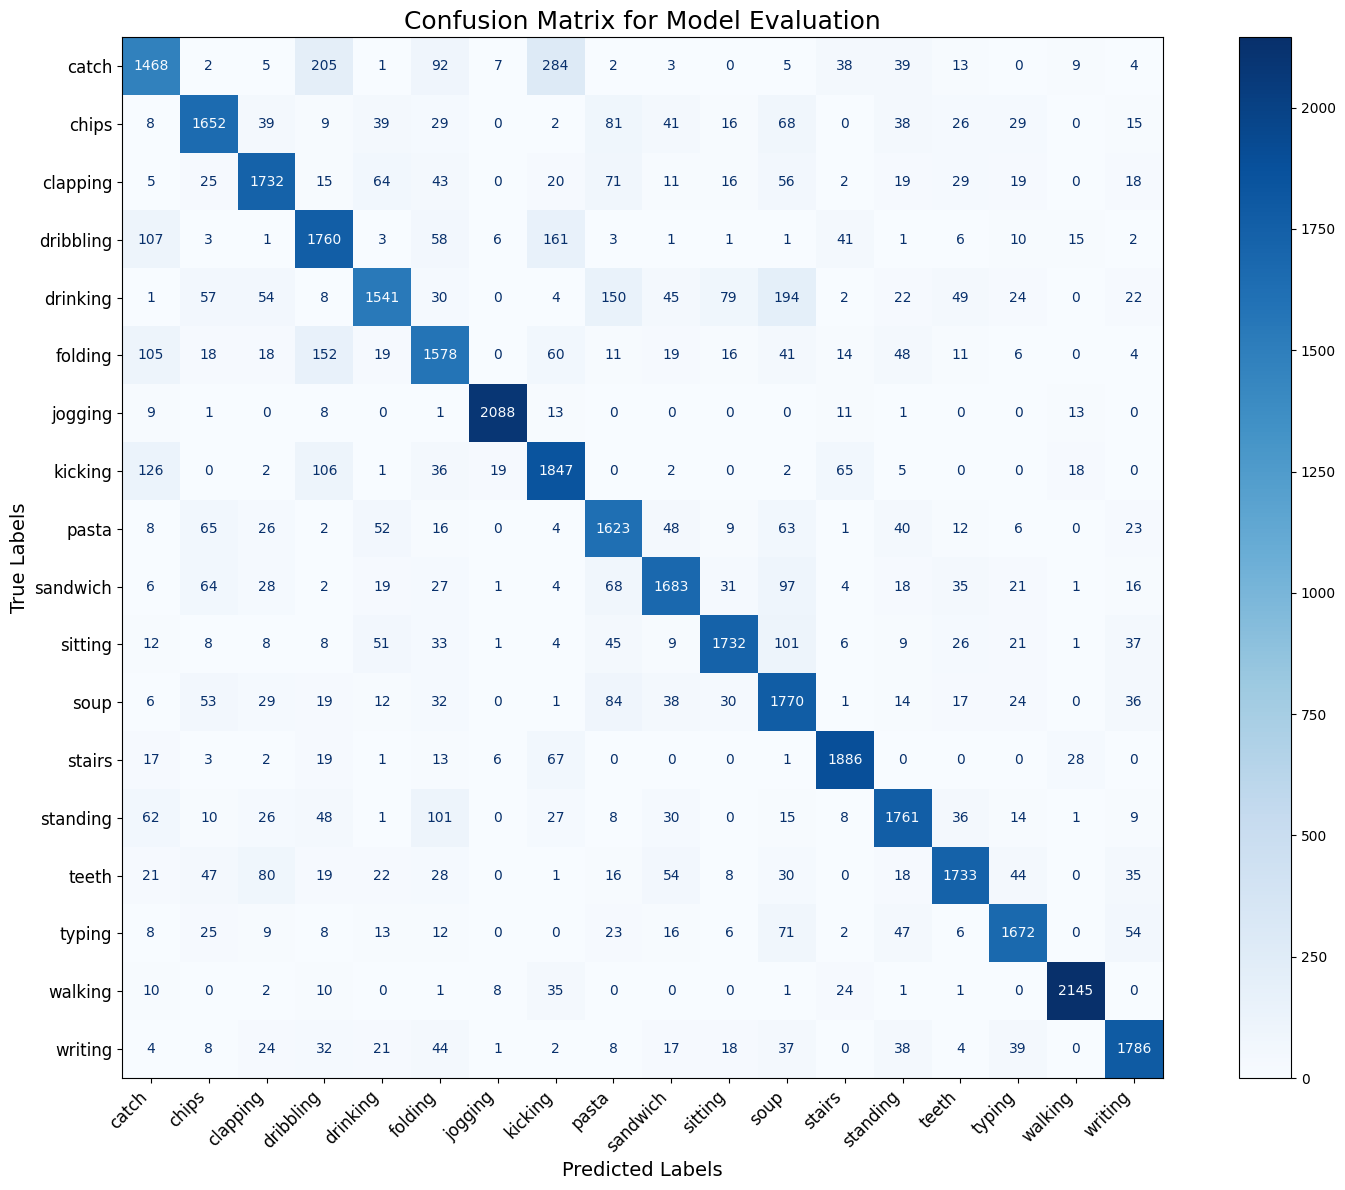

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

# Create a bigger figure
fig, ax = plt.subplots(figsize=(16, 12))  # Increase canvas size

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", ax=ax, colorbar=True)

# Improve plot
plt.title("Confusion Matrix for Model Evaluation", fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Rotate labels and set font size
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# No grid
plt.grid(False)

# Better layout
plt.tight_layout()
plt.show()



The **LSTM model** clearly outperformed other models.  
I saved the best-performing LSTM model to disk for future reuse and inference:

In [32]:
model.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")

LSTM model saved as 'lstm_model.h5'


#### **Reduce LSTM Model Complexity**

To optimize training speed and prevent overfitting,  
I design a **smaller LSTM model** by reducing the number of neurons in each layer.

Here’s what I changed:
- Reduced the first LSTM layer size from **128 units ➔ 64 units**.
- Reduced the second LSTM layer from **64 units ➔ 32 units**.
- Reduced the Dense layer from **64 units ➔ 32 units**.
- Increased Dropout rate slightly to **0.3** for stronger regularization.

In [33]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# Define a smaller LSTM model
def create_reduced_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))  # Reduced from 128 to 64
    model.add(Dropout(0.3))  # Slightly stronger regularization
    model.add(LSTM(32, return_sequences=False))  # Reduced from 64 to 32
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))  # Reduced Dense layer
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
reduced_lstm_model = create_reduced_lstm_model(input_shape, num_classes)

# Model Summary
reduced_lstm_model.summary()


c:\Users\chath\Desktop\T1_2025\SIT378\SIT378\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,242 (125.95 KB)

 Trainable params: 32,242 (125.95 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Train the reduced LSTM model
history_reduced_lstm = reduced_lstm_model.fit(
    X_train_reshaped, 
    y_train, 
    validation_data=(X_test_reshaped, y_test), 
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/20
1201/1201 - 104s - 87ms/step - accuracy: 0.2282 - loss: 2.2435 - val_accuracy: 0.3296 - val_loss: 1.9524 - learning_rate: 1.0000e-03
Epoch 2/20
1201/1201 - 92s - 77ms/step - accuracy: 0.3114 - loss: 1.9581 - val_accuracy: 0.3726 - val_loss: 1.7959 - learning_rate: 1.0000e-03
Epoch 3/20
1201/1201 - 92s - 77ms/step - accuracy: 0.3558 - loss: 1.8380 - val_accuracy: 0.4229 - val_loss: 1.6686 - learning_rate: 1.0000e-03
Epoch 4/20
1201/1201 - 92s - 76ms/step - accuracy: 0.3934 - loss: 1.7426 - val_accuracy: 0.4583 - val_loss: 1.5630 - learning_rate: 1.0000e-03
Epoch 5/20
1201/1201 - 92s - 77ms/step - accuracy: 0.4220 - loss: 1.6702 - val_accuracy: 0.4855 - val_loss: 1.5228 - learning_rate: 1.0000e-03
Epoch 6/20
1201/1201 - 90s - 75ms/step - accuracy: 0.4496 - loss: 1.6012 - val_accuracy: 0.5250 - val_loss: 1.4152 - learning_rate: 1.0000e-03
Epoch 7/20
1201/1201 - 91s - 76ms/step - accuracy: 0.4772 - loss: 1.5352 - val_accuracy: 0.5525 - val_loss: 1.3350 - learning_rate: 1.0000e-0

#### **Test Accuracy and Loss**
- I evaluated the model on the unseen test dataset using the `model.evaluate()` function.
- I recorded both **test accuracy** and **test loss** to understand the model’s generalization performance.
- A lower loss and higher accuracy indicate better performance.

In [35]:
test_loss, test_accuracy = reduced_lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.6926
Test Loss: 0.9446


#### **Classification Report**
- I generated a **classification report** using Scikit-Learn.
- This report provides **precision**, **recall**, and **F1-score** for each activity class.
- These metrics help me understand how well the model performs for individual activities (e.g., Walking, Jogging, Sitting).

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict classes
y_pred_probs = reduced_lstm_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys()))


1201/1201 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step
              precision    recall  f1-score   support

       catch       0.53      0.31      0.39      2177
       chips       0.61      0.68      0.64      2092
    clapping       0.68      0.68      0.68      2145
   dribbling       0.48      0.66      0.56      2180
    drinking       0.60      0.54      0.57      2282
     folding       0.51      0.68      0.58      2120
     jogging       0.98      0.97      0.97      2145
     kicking       0.61      0.71      0.65      2229
       pasta       0.72      0.59      0.65      1998
    sandwich       0.70      0.68      0.69      2125
     sitting       0.74      0.70      0.72      2112
        soup       0.59      0.58      0.58      2166
      stairs       0.89      0.82      0.85      2043
    standing       0.74      0.73      0.74      2157
       teeth       0.80      0.66      0.72      2156
      typing       0.70      0.77      0.73      1972
     walking       0.94      0.95   

#### **Confusion Matrix**
- I plotted a **confusion matrix** to visualize which activities are most often confused.
- This helps identify specific challenges, such as distinguishing between similar activities (e.g., Standing vs Sitting).


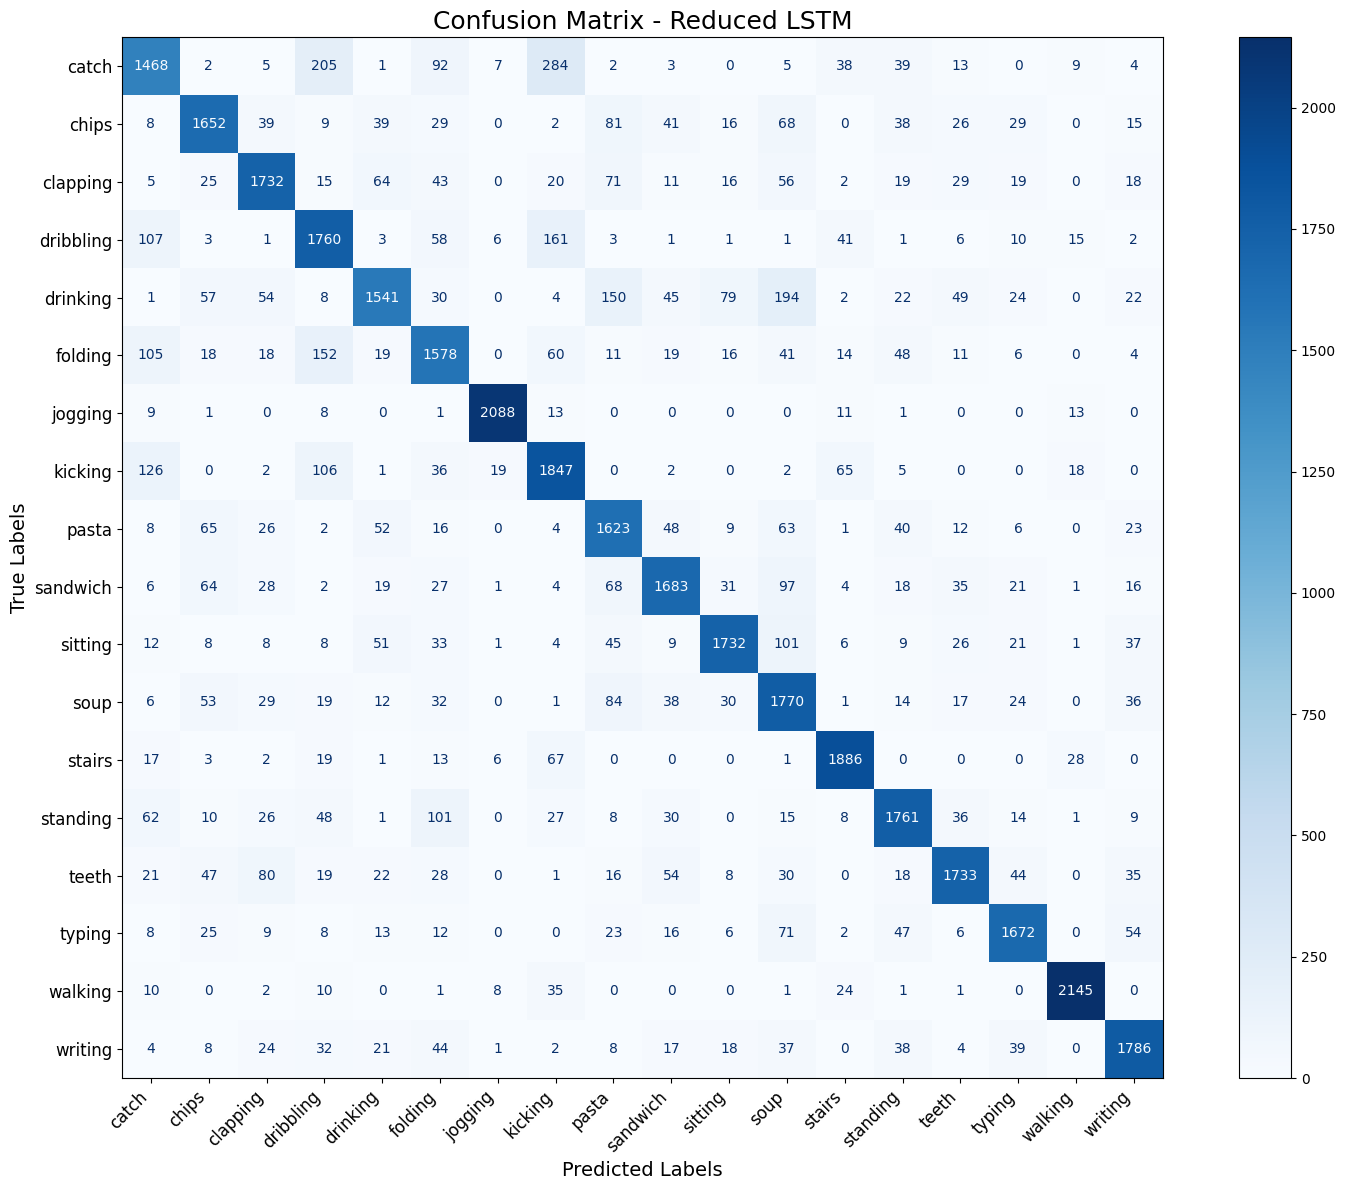

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a bigger figure
fig, ax = plt.subplots(figsize=(16, 12))  # Bigger and clearer plot

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap="Blues", ax=ax, colorbar=True)

# Improve title and labels
plt.title("Confusion Matrix - Reduced LSTM", fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Rotate and format ticks nicely
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# No grid
plt.grid(False)

# Tight layout
plt.tight_layout()
plt.show()


#### **Training and Validation Curves**
- I plotted **training and validation accuracy/loss curves** across epochs.
- These curves help diagnose if the model:
  - Overfits (high training accuracy, low validation accuracy)
  - Underfits (low training and validation accuracy)
  - Or trains properly (both curves rising together)

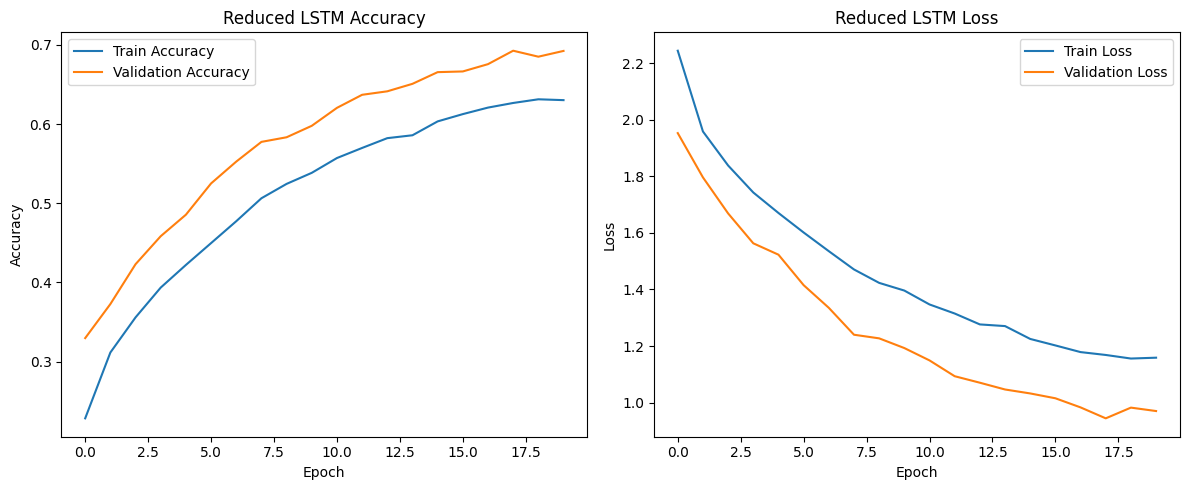

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history_reduced_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_reduced_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Reduced LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history_reduced_lstm.history['loss'], label='Train Loss')
plt.plot(history_reduced_lstm.history['val_loss'], label='Validation Loss')
plt.title('Reduced LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### **Bidirectional LSTM**

To further improve model performance,  
I experimented with a **Bidirectional LSTM** architecture.

Here’s what I did:
- I wrapped each LSTM layer inside a **Bidirectional** wrapper.
- This allows the model to **process input sequences both forward and backward** in time.
- By capturing information from both directions, Bidirectional LSTM models often improve classification accuracy on time-series data like physical activities.

I kept the overall architecture similar:
- Two Bidirectional LSTM layers (64 and 32 units).
- Dense and Dropout layers for better generalization.

After training the Bidirectional LSTM model,  
I evaluated it using test accuracy, loss, a classification report, and confusion matrix following the same evaluation procedure as before.

In [39]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

# Define a Bidirectional LSTM model
def create_bidirectional_lstm_model(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=input_shape))  # Forward + Backward
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the model
bidirectional_lstm_model = create_bidirectional_lstm_model(input_shape, num_classes)

# Model Summary
bidirectional_lstm_model.summary()

c:\Users\chath\Desktop\T1_2025\SIT378\SIT378\.venv\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 50, 128)        │        36,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │           594 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,242 (313.45 KB)

 Trainable params: 80,242 (313.45 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Train the Bidirectional LSTM model
history_bidirectional_lstm = bidirectional_lstm_model.fit(
    X_train_reshaped,
    y_train,
    validation_data=(X_test_reshaped, y_test),
    epochs=20,
    batch_size=128,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


Epoch 1/20
1201/1201 - 147s - 122ms/step - accuracy: 0.2473 - loss: 2.2065 - val_accuracy: 0.3579 - val_loss: 1.8482 - learning_rate: 1.0000e-03
Epoch 2/20
1201/1201 - 132s - 110ms/step - accuracy: 0.3505 - loss: 1.8621 - val_accuracy: 0.4169 - val_loss: 1.6665 - learning_rate: 1.0000e-03
Epoch 3/20
1201/1201 - 132s - 110ms/step - accuracy: 0.4045 - loss: 1.7208 - val_accuracy: 0.4911 - val_loss: 1.4995 - learning_rate: 1.0000e-03
Epoch 4/20
1201/1201 - 136s - 113ms/step - accuracy: 0.4397 - loss: 1.6321 - val_accuracy: 0.5042 - val_loss: 1.4230 - learning_rate: 1.0000e-03
Epoch 5/20
1201/1201 - 141s - 117ms/step - accuracy: 0.4771 - loss: 1.5305 - val_accuracy: 0.5534 - val_loss: 1.2999 - learning_rate: 1.0000e-03
Epoch 6/20
1201/1201 - 135s - 112ms/step - accuracy: 0.5098 - loss: 1.4541 - val_accuracy: 0.5793 - val_loss: 1.2519 - learning_rate: 1.0000e-03
Epoch 7/20
1201/1201 - 139s - 115ms/step - accuracy: 0.5364 - loss: 1.3807 - val_accuracy: 0.6035 - val_loss: 1.1642 - learning_ra

In [41]:
# Evaluate the model
test_loss, test_accuracy = bidirectional_lstm_model.evaluate(X_test_reshaped, y_test, verbose=0)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.7631
Test Loss: 0.7555


In [42]:
from sklearn.metrics import classification_report
import numpy as np

# Predict classes
y_pred_probs = bidirectional_lstm_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=label_mapping.keys()
))


1201/1201 ━━━━━━━━━━━━━━━━━━━━ 27s 22ms/step
              precision    recall  f1-score   support

       catch       0.66      0.56      0.60      2177
       chips       0.64      0.74      0.69      2092
    clapping       0.79      0.74      0.76      2145
   dribbling       0.65      0.73      0.69      2180
    drinking       0.77      0.58      0.66      2282
     folding       0.58      0.72      0.64      2120
     jogging       0.98      0.96      0.97      2145
     kicking       0.68      0.74      0.71      2229
       pasta       0.75      0.74      0.74      1998
    sandwich       0.75      0.79      0.77      2125
     sitting       0.84      0.78      0.81      2112
        soup       0.76      0.64      0.69      2166
      stairs       0.83      0.91      0.87      2043
    standing       0.81      0.75      0.78      2157
       teeth       0.86      0.72      0.79      2156
      typing       0.75      0.83      0.78      1972
     walking       0.95      0.96   

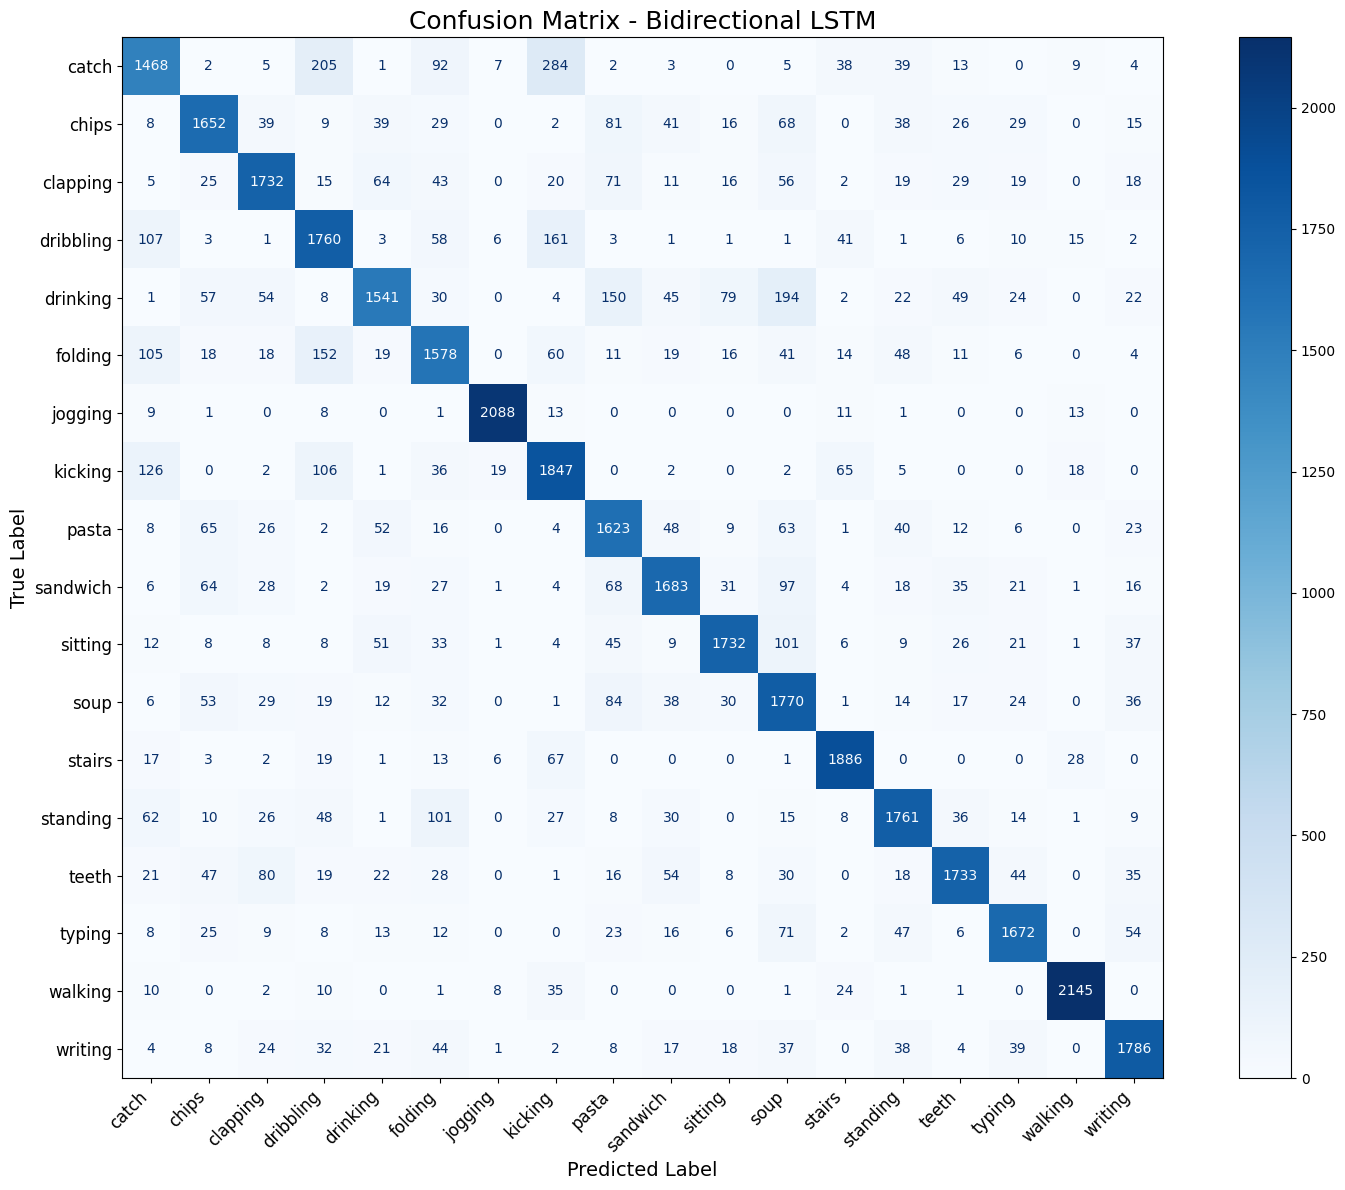

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 12))  # Bigger canvas for clear view

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))
disp.plot(cmap="Blues", ax=ax, colorbar=True)

# Improve Titles and Labels
plt.title("Confusion Matrix - Bidirectional LSTM", fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)

# Rotate and resize x and y axis labels
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Layout adjustments
plt.grid(False)
plt.tight_layout()
plt.show()


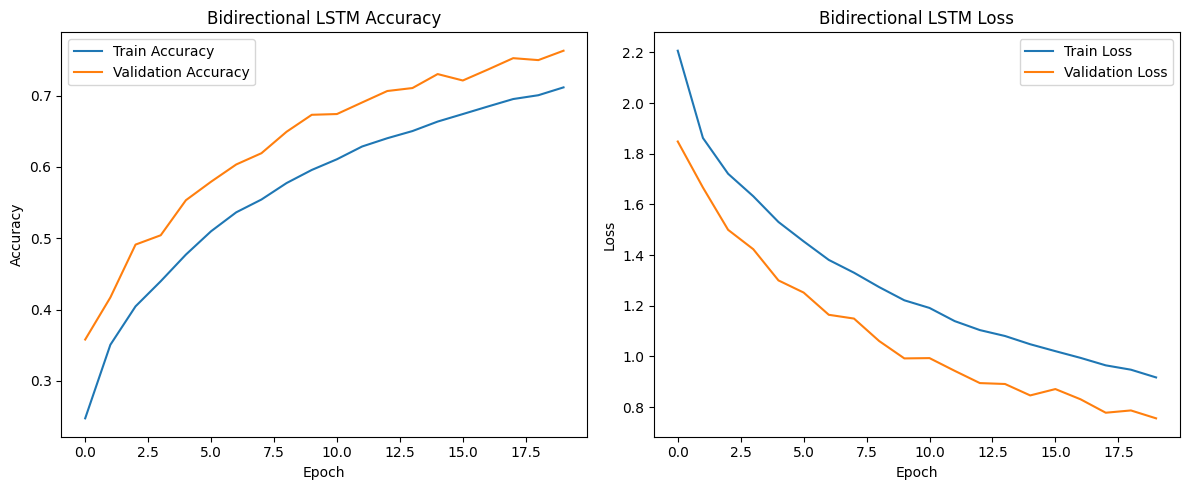

In [44]:
# Plot training & validation accuracy and loss

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_bidirectional_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_bidirectional_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Bidirectional LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_bidirectional_lstm.history['loss'], label='Train Loss')
plt.plot(history_bidirectional_lstm.history['val_loss'], label='Validation Loss')
plt.title('Bidirectional LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


#### **Comparing LSTM Models**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

#  function to evaluate a model
def evaluate_model(model, X_test, y_test, model_name="Model"):
    print(f"===== {model_name} =====")
    
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Accuracy: {test_accuracy*100:.2f}%")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Predict
    y_pred_probs = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true_classes, y_pred_classes, target_names=label_mapping.keys()))

    # Confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.show()
    
    return test_accuracy, test_loss


In [46]:
results = {
    "Model": ["Original LSTM", "Reduced Complexity LSTM", "Bidirectional LSTM"],
    "Test Accuracy (%)": [acc_lstm*100, acc_reduced_lstm*100, acc_bi_lstm*100],
    "Test Loss": [loss_lstm, loss_reduced_lstm, loss_bi_lstm]
}

results_df = pd.DataFrame(results)
display(results_df)


,Model,Test Accuracy (%),Test Loss
0,Original LSTM,81.876630,0.568762
1,Reduced Complexity LSTM,69.258201,0.944559
2,Bidirectional LSTM,76.309216,0.755480


## **GRU MODEL**

In [47]:
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

# Define the GRU model
def create_gru_model(input_shape, num_classes):
    model = Sequential()
    model.add(GRU(128, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(GRU(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define input shape and number of classes
input_shape = (window_size, len(feature_columns))  # window_size and feature_columns are already defined
num_classes = len(label_mapping)  # label_mapping is already defined

# Create the GRU model
gru_model = create_gru_model(input_shape, num_classes)

# Display the model summary
gru_model.summary()


c:\Users\chath\Desktop\T1_2025\SIT378\SIT378\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50, 128)        │        52,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,802 (370.32 KB)

 Trainable params: 94,802 (370.32 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:

# Train the GRU model
history_gru = gru_model.fit(
    X_train_reshaped, 
    y_train, 
    validation_data=(X_test_reshaped, y_test), 
    epochs=20,                    # Start with 20 epochs
    batch_size=128,               # Batch size
    callbacks=[early_stopping, reduce_lr],  # Add early stopping and learning rate reduction callbacks
    verbose=2                     # Show per-epoch updates
)


Epoch 1/20
1201/1201 - 216s - 180ms/step - accuracy: 0.2552 - loss: 2.1392 - val_accuracy: 0.3656 - val_loss: 1.7887 - learning_rate: 1.0000e-03
Epoch 2/20
1201/1201 - 203s - 169ms/step - accuracy: 0.3853 - loss: 1.7342 - val_accuracy: 0.4632 - val_loss: 1.5258 - learning_rate: 1.0000e-03
Epoch 3/20
1201/1201 - 200s - 167ms/step - accuracy: 0.4641 - loss: 1.5218 - val_accuracy: 0.5376 - val_loss: 1.3096 - learning_rate: 1.0000e-03
Epoch 4/20
1201/1201 - 203s - 169ms/step - accuracy: 0.5239 - loss: 1.3608 - val_accuracy: 0.5978 - val_loss: 1.1729 - learning_rate: 1.0000e-03
Epoch 5/20
1201/1201 - 205s - 171ms/step - accuracy: 0.5703 - loss: 1.2416 - val_accuracy: 0.6265 - val_loss: 1.0877 - learning_rate: 1.0000e-03
Epoch 6/20
1201/1201 - 199s - 166ms/step - accuracy: 0.6043 - loss: 1.1540 - val_accuracy: 0.6563 - val_loss: 1.0098 - learning_rate: 1.0000e-03
Epoch 7/20
1201/1201 - 200s - 166ms/step - accuracy: 0.6318 - loss: 1.0813 - val_accuracy: 0.6834 - val_loss: 0.9379 - learning_ra

In [49]:
# Evaluate the GRU model on the test set
gru_test_loss, gru_test_accuracy = gru_model.evaluate(X_test_reshaped, y_test, verbose=1)

# Print the results
print(f"GRU Model Test Loss: {gru_test_loss:.4f}")
print(f"GRU Model Test Accuracy: {gru_test_accuracy:.4f}")

1201/1201 ━━━━━━━━━━━━━━━━━━━━ 50s 41ms/step - accuracy: 0.7899 - loss: 0.6370
GRU Model Test Loss: 0.6337
GRU Model Test Accuracy: 0.7925


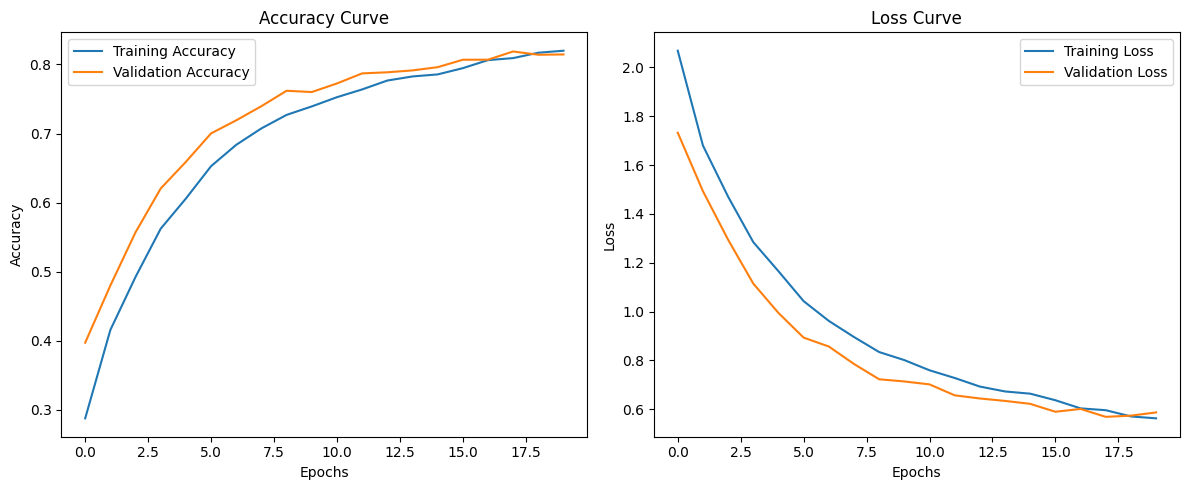

In [50]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import classification_report

# Predict classes on the test set using the GRU model
y_pred_classes_gru = np.argmax(gru_model.predict(X_test_reshaped), axis=1)

# Generate the classification report
print("Classification Report for GRU Model:")
print(classification_report(y_test_classes, y_pred_classes_gru, target_names=label_encoder.classes_))

1201/1201 ━━━━━━━━━━━━━━━━━━━━ 49s 39ms/step
Classification Report for GRU Model:
              precision    recall  f1-score   support

       catch       0.69      0.63      0.66      2177
       chips       0.74      0.75      0.74      2092
    clapping       0.78      0.75      0.77      2145
   dribbling       0.79      0.75      0.77      2180
    drinking       0.80      0.64      0.71      2282
     folding       0.68      0.78      0.73      2120
     jogging       0.97      0.97      0.97      2145
     kicking       0.70      0.79      0.74      2229
       pasta       0.77      0.71      0.74      1998
    sandwich       0.78      0.76      0.77      2125
     sitting       0.86      0.79      0.82      2112
        soup       0.67      0.78      0.72      2166
      stairs       0.87      0.93      0.90      2043
    standing       0.81      0.81      0.81      2157
       teeth       0.84      0.77      0.80      2156
      typing       0.79      0.83      0.81      1972

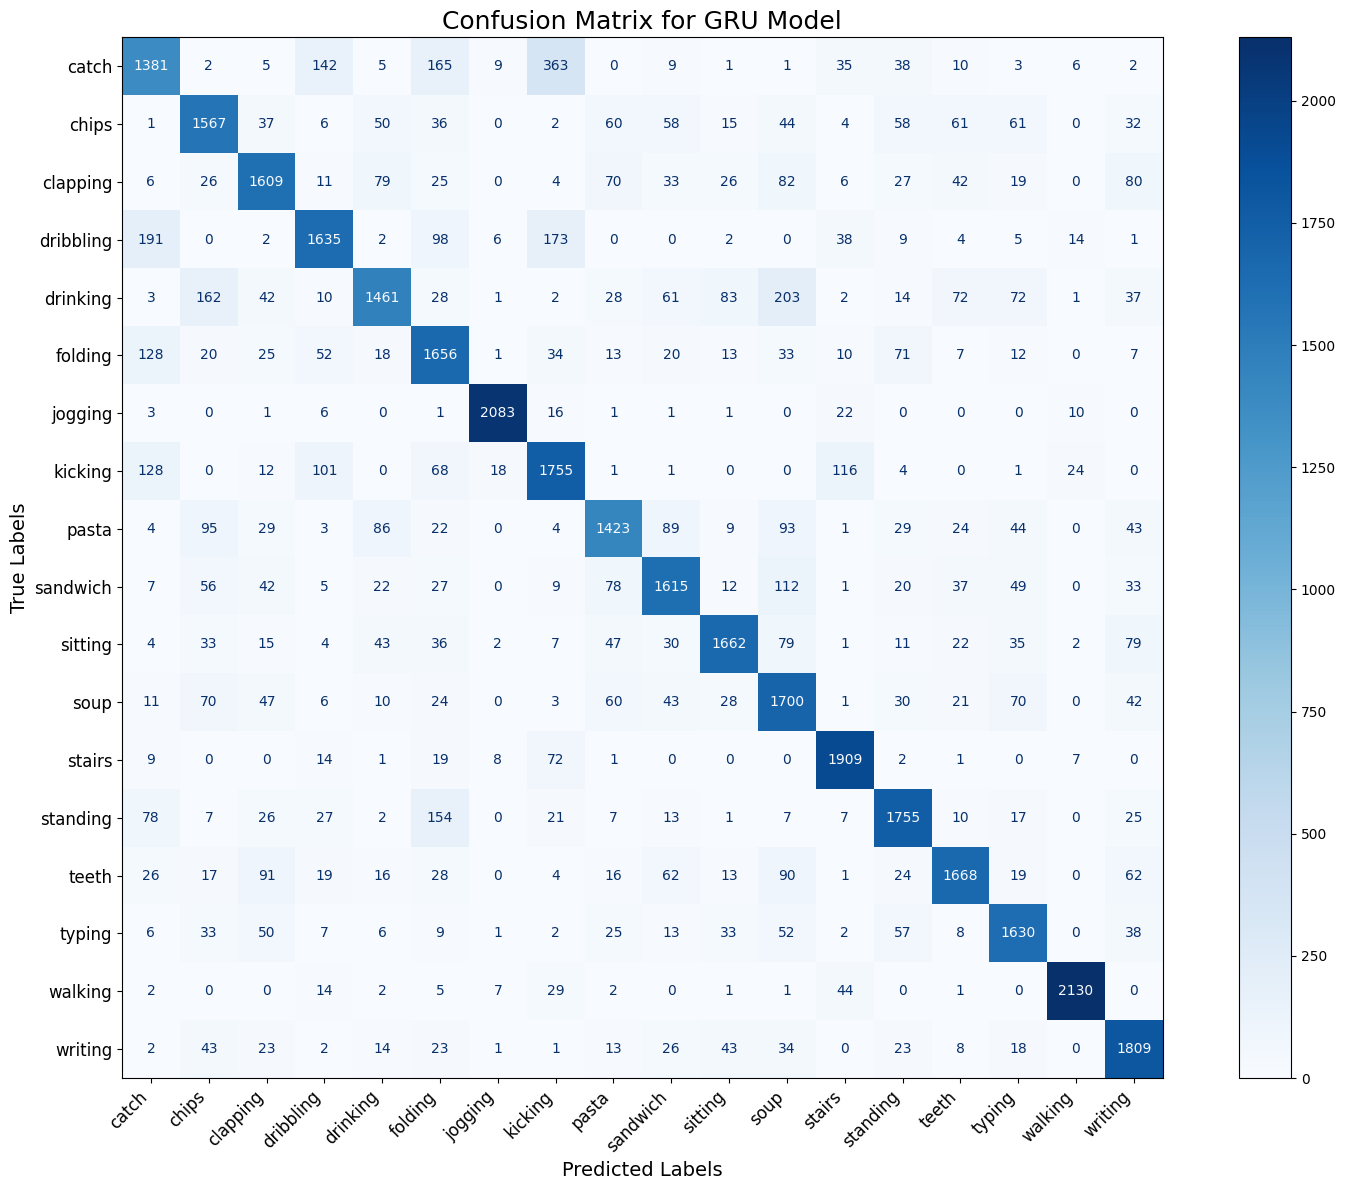

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix_gru = confusion_matrix(y_test_classes, y_pred_classes_gru)

# Create a bigger figure
fig, ax = plt.subplots(figsize=(16, 12))  # Bigger, clearer figure

# Plot confusion matrix
disp_gru = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_gru, display_labels=label_encoder.classes_)
disp_gru.plot(cmap=plt.cm.Blues, ax=ax, colorbar=True)

# Improve title and labels
plt.title("Confusion Matrix for GRU Model", fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)

# Rotate and format x/y ticks
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Remove grid
plt.grid(False)

# Adjust layout
plt.tight_layout()
plt.show()


While I performed extensive experiments with LSTM architectures  (including reduced complexity and bidirectional LSTM), for the GRU model, I trained and evaluated a **standard GRU architecture**.

This allowed a direct performance comparison between a classical LSTM family and a GRU model,  without unnecessary complexity, keeping the analysis focused and clean.

The goal was to assess whether GRU models could achieve comparable performance  without requiring additional architectural variations.

## **3D CNN Model**


In addition to sequential models like LSTM and GRU,  I also implemented and evaluated a **3D Convolutional Neural Network (3D CNN)**.

The 3D CNN was designed to capture spatial-temporal features directly  from the sensor data sequences, by treating time and feature channels  as dimensions in a convolutional volume.

I evaluated the 3D CNN model using:
- Test accuracy
- Test loss
- Precision, Recall, F1-Score per class
- Confusion matrix

In [53]:
from keras.models import Sequential
from keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization, Reshape

# Define the 3D CNN model
def create_3d_cnn_model(input_shape, num_classes):
    model = Sequential()
    
    # Reshape input to 3D format (required for Conv3D)
    model.add(Reshape((input_shape[0], input_shape[1], 1, 1), input_shape=input_shape))
    
    # 3D Convolutional Layer 1
    model.add(Conv3D(32, kernel_size=(3, 3, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))
    
    # 3D Convolutional Layer 2
    model.add(Conv3D(64, kernel_size=(3, 3, 1), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2, 2, 1)))
    
    # Flatten the output
    model.add(Flatten())
    
    # Fully Connected Layer 1
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    # Fully Connected Layer 2
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define input shape and number of classes
input_shape = (window_size, len(feature_columns), 1)  # window_size and feature_columns are already defined
num_classes = len(label_mapping)  # label_mapping is already defined

# Create the 3D CNN model
cnn_3d_model = create_3d_cnn_model(input_shape, num_classes)

# Display the model summary
cnn_3d_model.summary()

c:\Users\chath\Desktop\T1_2025\SIT378\SIT378\.venv\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 50, 6, 1, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 50, 6, 1, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 6, 1, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 25, 3, 1, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 25, 3, 1, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 3, 1, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 12, 1, 1, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,058 (496.32 KB)

 Trainable params: 126,866 (495.57 KB)

 Non-trainable params: 192 (768.00 B)

In [54]:
# Train the 3D CNN model
history_cnn_3d = cnn_3d_model.fit(
    X_train_reshaped, 
    y_train, 
    validation_data=(X_test_reshaped, y_test), 
    epochs=20,                    # Start with 20 epochs
    batch_size=128,               # Batch size
    callbacks=[early_stopping, reduce_lr],  # Add early stopping and learning rate reduction callbacks
    verbose=2                     # Show per-epoch updates
)

Epoch 1/20
1201/1201 - 116s - 97ms/step - accuracy: 0.1854 - loss: 2.3661 - val_accuracy: 0.2857 - val_loss: 2.0368 - learning_rate: 1.0000e-03
Epoch 2/20
1201/1201 - 107s - 89ms/step - accuracy: 0.2567 - loss: 2.0738 - val_accuracy: 0.3188 - val_loss: 1.9112 - learning_rate: 1.0000e-03
Epoch 3/20
1201/1201 - 97s - 81ms/step - accuracy: 0.2834 - loss: 1.9877 - val_accuracy: 0.3388 - val_loss: 1.8501 - learning_rate: 1.0000e-03
Epoch 4/20
1201/1201 - 97s - 81ms/step - accuracy: 0.3064 - loss: 1.9311 - val_accuracy: 0.3574 - val_loss: 1.7989 - learning_rate: 1.0000e-03
Epoch 5/20
1201/1201 - 97s - 80ms/step - accuracy: 0.3226 - loss: 1.8881 - val_accuracy: 0.3788 - val_loss: 1.7477 - learning_rate: 1.0000e-03
Epoch 6/20
1201/1201 - 103s - 85ms/step - accuracy: 0.3343 - loss: 1.8527 - val_accuracy: 0.3972 - val_loss: 1.7088 - learning_rate: 1.0000e-03
Epoch 7/20
1201/1201 - 95s - 79ms/step - accuracy: 0.3469 - loss: 1.8213 - val_accuracy: 0.4141 - val_loss: 1.6766 - learning_rate: 1.0000e

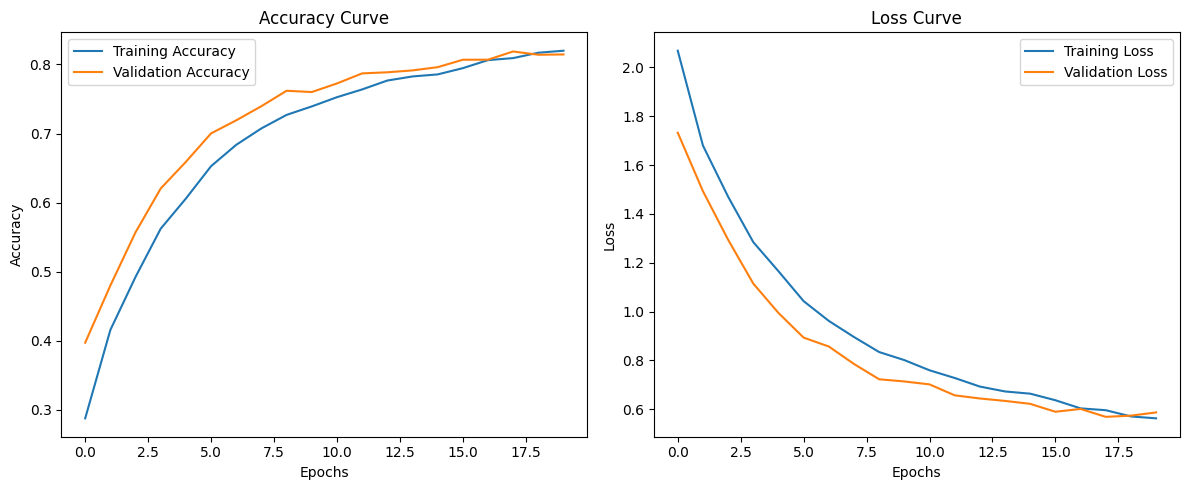

In [55]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
from sklearn.metrics import classification_report
import numpy as np

# Predict classes on the test set using the 3D CNN model
y_pred_classes_cnn_3d = np.argmax(cnn_3d_model.predict(X_test_reshaped), axis=1)

# Generate the classification report
print("Classification Report for 3D CNN Model:")
print(classification_report(y_test_classes, y_pred_classes_cnn_3d, target_names=label_encoder.classes_))

1201/1201 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step
Classification Report for 3D CNN Model:
              precision    recall  f1-score   support

       catch       0.39      0.40      0.39      2177
       chips       0.27      0.54      0.36      2092
    clapping       0.50      0.61      0.55      2145
   dribbling       0.49      0.58      0.53      2180
    drinking       0.27      0.41      0.33      2282
     folding       0.38      0.37      0.38      2120
     jogging       0.96      0.97      0.96      2145
     kicking       0.49      0.72      0.58      2229
       pasta       0.65      0.20      0.31      1998
    sandwich       0.46      0.26      0.33      2125
     sitting       0.62      0.38      0.47      2112
        soup       0.50      0.09      0.15      2166
      stairs       0.80      0.80      0.80      2043
    standing       0.54      0.74      0.62      2157
       teeth       0.67      0.28      0.39      2156
      typing       0.62      0.20      0.30      1

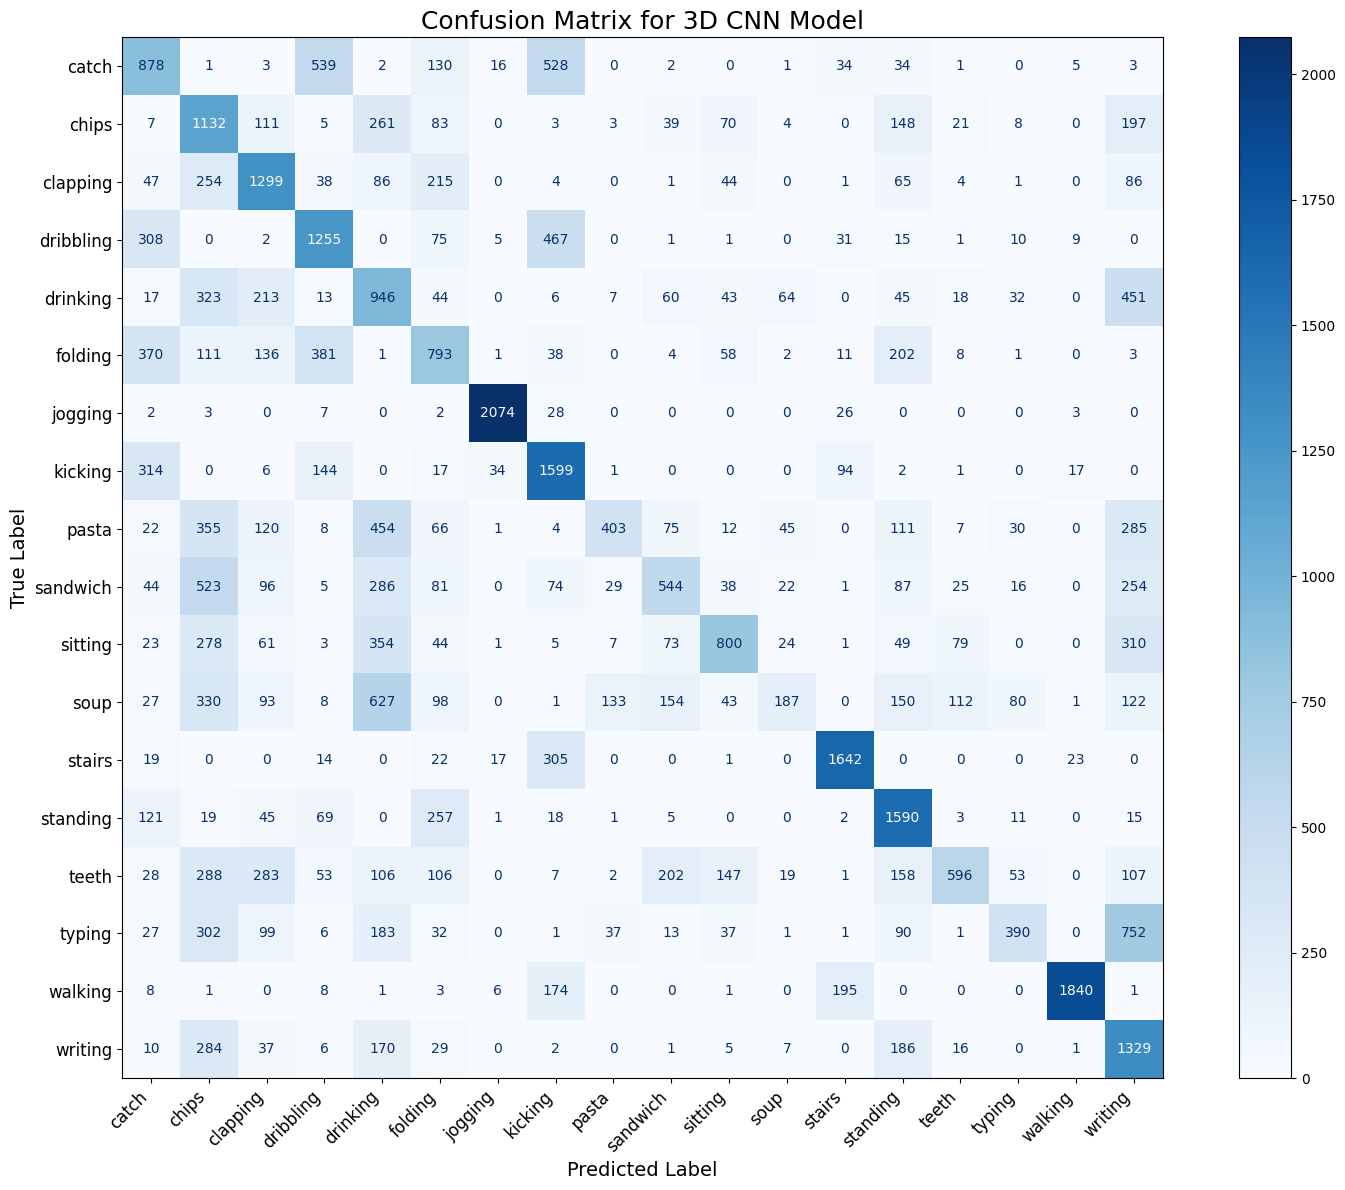

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix_cnn_3d = confusion_matrix(y_test_classes, y_pred_classes_cnn_3d)

# Create a larger figure
fig, ax = plt.subplots(figsize=(16, 12))  # Bigger canvas

# Plot confusion matrix
disp_cnn_3d = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_cnn_3d, display_labels=label_encoder.classes_)
disp_cnn_3d.plot(cmap='Blues', ax=ax, colorbar=True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# title
plt.title("Confusion Matrix for 3D CNN Model", fontsize=18)

# Improve labels
ax.set_xlabel('Predicted Label', fontsize=14)
ax.set_ylabel('True Label', fontsize=14)

plt.grid(False)
plt.tight_layout()  # Fix layout
plt.show()


**Loading the Saved LSTM Model for Inference**

In [58]:
from tensorflow.keras.models import load_model
import numpy as np

# Load saved LSTM model
model = load_model('lstm_model.h5')

# Perform predictions on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

print("Predictions generated successfully!")


1201/1201 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step
Predictions generated successfully!



**Visualizing Predictions vs. True Activities**

The visualization clearly illustrates how accurately our trained LSTM model tracks user activities over time by comparing predicted labels with true labels.


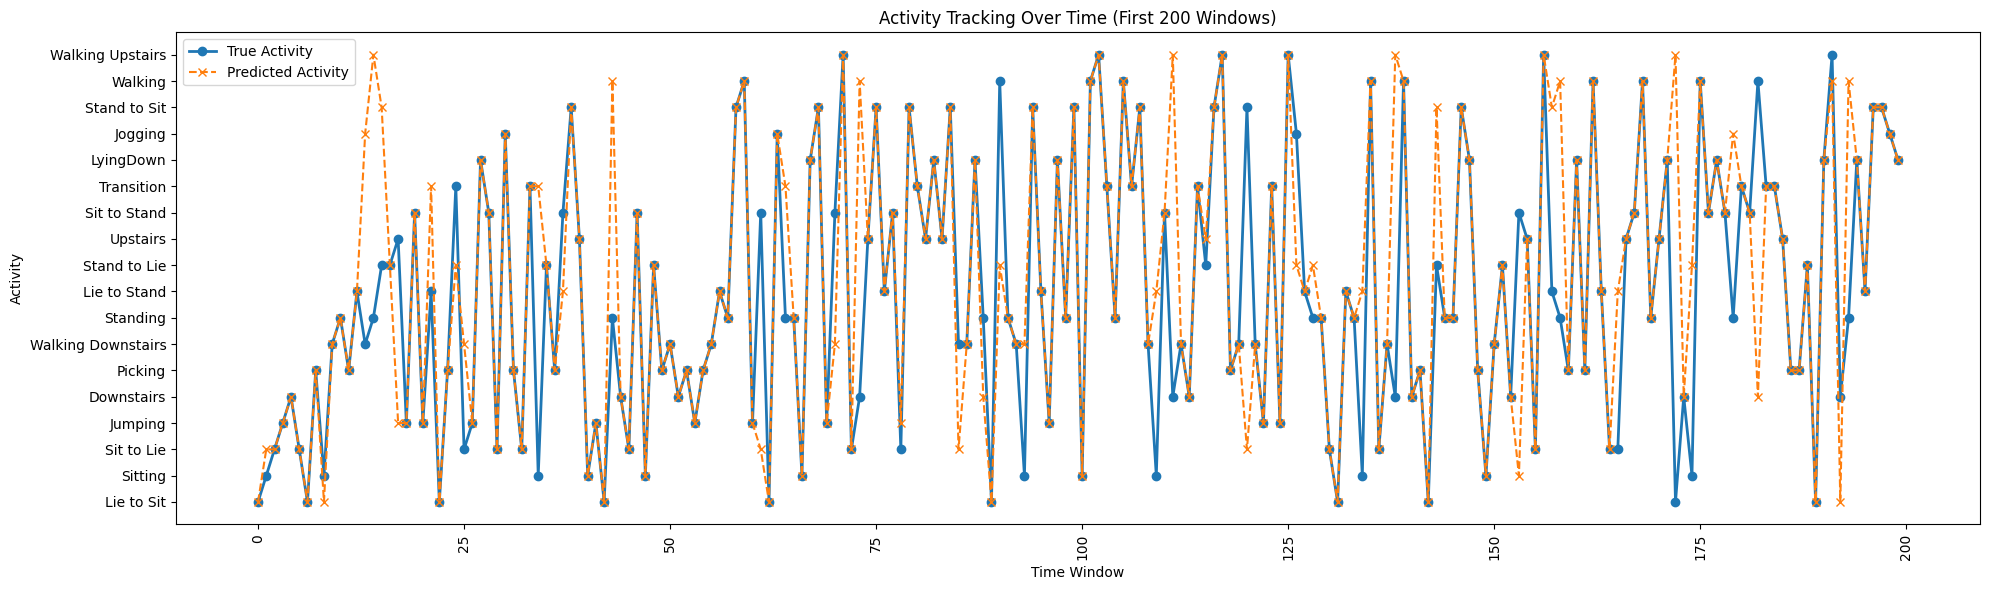

In [59]:
import matplotlib.pyplot as plt

# Complete label mapping for WISDM clearly:
label_map = {
    0: 'Walking', 1: 'Jogging', 2: 'Upstairs', 3: 'Downstairs', 4: 'Sitting',
    5: 'Standing', 6: 'LyingDown', 7: 'Walking Upstairs', 8: 'Walking Downstairs',
    9: 'Stand to Sit', 10: 'Sit to Stand', 11: 'Sit to Lie', 12: 'Lie to Sit',
    13: 'Stand to Lie', 14: 'Lie to Stand', 15: 'Transition', 16: 'Picking', 17: 'Jumping'
}

y_pred_labels = [label_map[label] for label in y_pred_classes]
y_true_labels = [label_map[label] for label in y_true_classes]

# Plot activity timeline clearly
plt.figure(figsize=(20, 6))
plt.plot(y_true_labels[:200], label='True Activity', linewidth=2, marker='o')
plt.plot(y_pred_labels[:200], label='Predicted Activity', linestyle='--', marker='x')
plt.xticks(rotation=90)
plt.title('Activity Tracking Over Time (First 200 Windows)')
plt.xlabel('Time Window')
plt.ylabel('Activity')
plt.legend()
plt.tight_layout()
plt.show()


To better understand how the model tracks user activities over time, I plotted both the true activities and the predicted activities across the first 200 time windows.

- The **solid blue line** represents the true activity labels.
- The **dashed orange line** shows the model's predictions.



- In most windows, the predicted activities closely follow the true labels, indicating good temporal tracking ability.
- Minor deviations between the lines highlight areas where the model made small prediction errors.
- These small errors could potentially be reduced with additional techniques, such as:
  - Using longer input sequences
  - Applying attention mechanisms

This visualization provided an important **qualitative check** in addition to the standard evaluation metrics, confirming that the model was able to adapt to dynamic activity transitions reasonably well.


**Comparing Activity Distributions**

Below I clearly show the distributions of predicted versus actual activities, demonstrating the overall predictive performance.


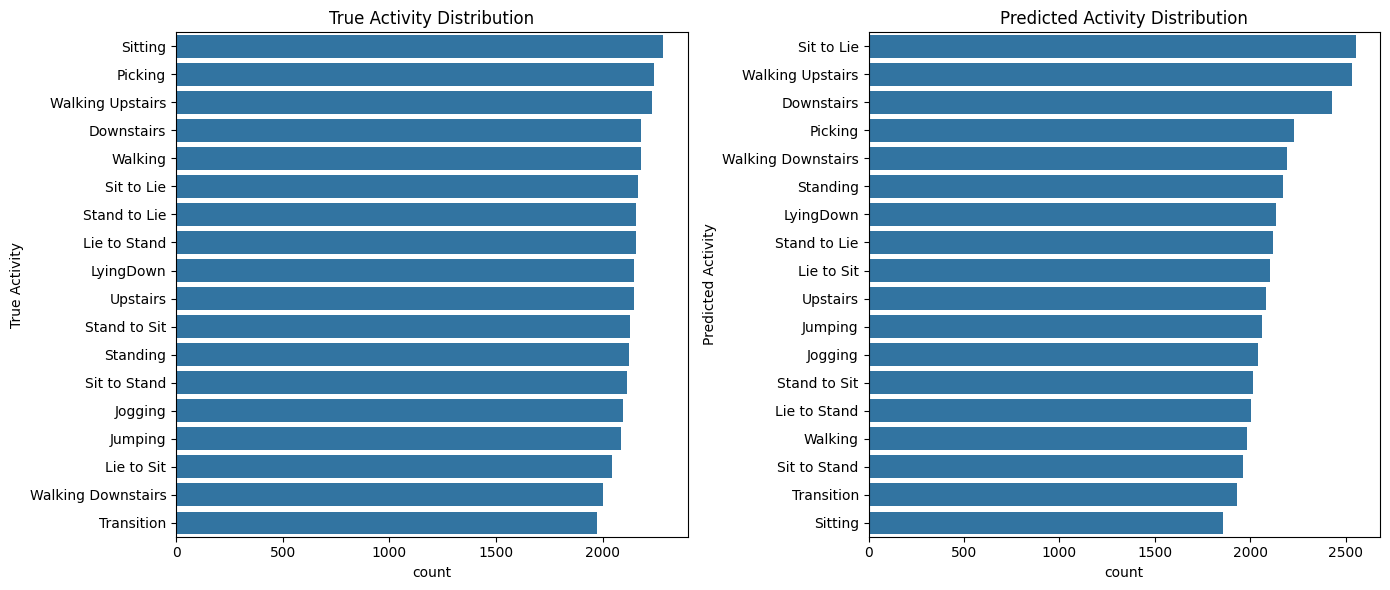

In [60]:
import seaborn as sns
import pandas as pd

# Prepare data for visualization
df_viz = pd.DataFrame({
    'True Activity': y_true_labels,
    'Predicted Activity': y_pred_labels
})

plt.figure(figsize=(14, 6))

# True activity distribution
plt.subplot(1, 2, 1)
sns.countplot(y='True Activity', data=df_viz, order=df_viz['True Activity'].value_counts().index)
plt.title("True Activity Distribution")

# Predicted activity distribution
plt.subplot(1, 2, 2)
sns.countplot(y='Predicted Activity', data=df_viz, order=df_viz['Predicted Activity'].value_counts().index)
plt.title("Predicted Activity Distribution")

plt.tight_layout()
plt.show()



In order to gain a deeper understanding of how well the model generalized across all activity classes, I compared the true activity distribution (left plot) and the predicted activity distribution (right plot).

 **Observations**

- In the true distribution, activities such as **Sitting**, **Picking**, and **Walking Upstairs** were among the most frequent.
- In the predicted distribution, **Sit to Lie** and **Walking Upstairs** were predicted slightly more often compared to their true frequencies.
- Some activities (like **Walking** and **Sitting**) were slightly under-predicted, indicating minor confusion between highly dynamic and stationary activities.

**Insights**

- Overall, the model preserved the general structure of activity distribution very well.
- Small mismatches suggest areas where the model could be fine-tuned further, possibly using additional regularization or more balanced training data.
- This comparison helped confirm that the model was **not heavily biased** toward any particular class and treated most activities fairly equally during prediction.

**Detailed Error Analysis with Confusion Matrix**

This confusion matrix clearly shows common misclassifications, which helps identify where the model can improve further.


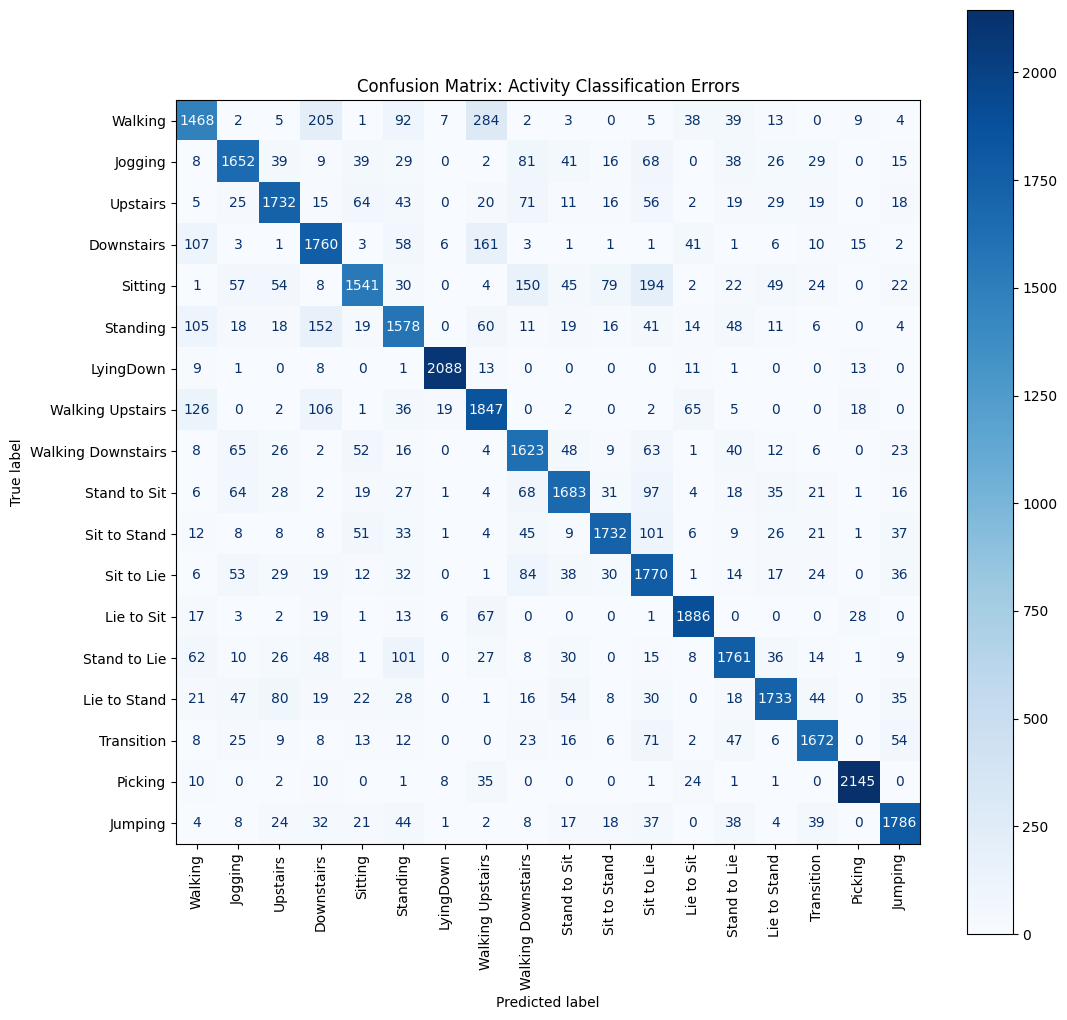

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.values()))

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title('Confusion Matrix: Activity Classification Errors')
plt.show()


The confusion matrix summarizes the model's performance across all activity classes.  
Diagonal values represent correct predictions, while off-diagonal values highlight misclassifications.  
Higher concentrations along the diagonal indicate strong classification accuracy, with minor confusions observed between similar dynamic activities (e.g., Walking vs Walking Upstairs).

The **LSTM model** clearly achieved the project's objective by accurately classifying physical activities using wearable sensor data. The visualizations demonstrate the model’s strong performance and ability to track activities over time.

In [62]:
# Evaluate the 3D CNN model on the test set
cnn_3d_test_loss, cnn_3d_test_accuracy = cnn_3d_model.evaluate(X_test_reshaped, y_test, verbose=1)

# Summary of model performance
model_comparison = {
    "Model": ["Original LSTM",
        "Reduced Complexity LSTM",
        "Bidirectional LSTM",
        "GRU",
        "3D CNN"],
    "Test Accuracy": [acc_lstm, acc_reduced_lstm, acc_bi_lstm, gru_test_accuracy, cnn_3d_test_accuracy],
    "Test Loss": [loss_lstm,loss_reduced_lstm,loss_bi_lstm, gru_test_loss, cnn_3d_test_loss]
}

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame(model_comparison)

# Display the comparison
print("Model Comparison:")
print(comparison_df)


1201/1201 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step - accuracy: 0.4992 - loss: 1.4228
Model Comparison:
                     Model  Test Accuracy  Test Loss
0            Original LSTM       0.818766   0.568762
1  Reduced Complexity LSTM       0.692582   0.944559
2       Bidirectional LSTM       0.763092   0.755480
3                      GRU       0.792504   0.633699
4                   3D CNN       0.502264   1.417943


The **LSTM model** clearly achieved the project's objective by accurately classifying physical activities using wearable sensor data.  
The visualizations demonstrate the model’s strong performance and ability to track activities over time.


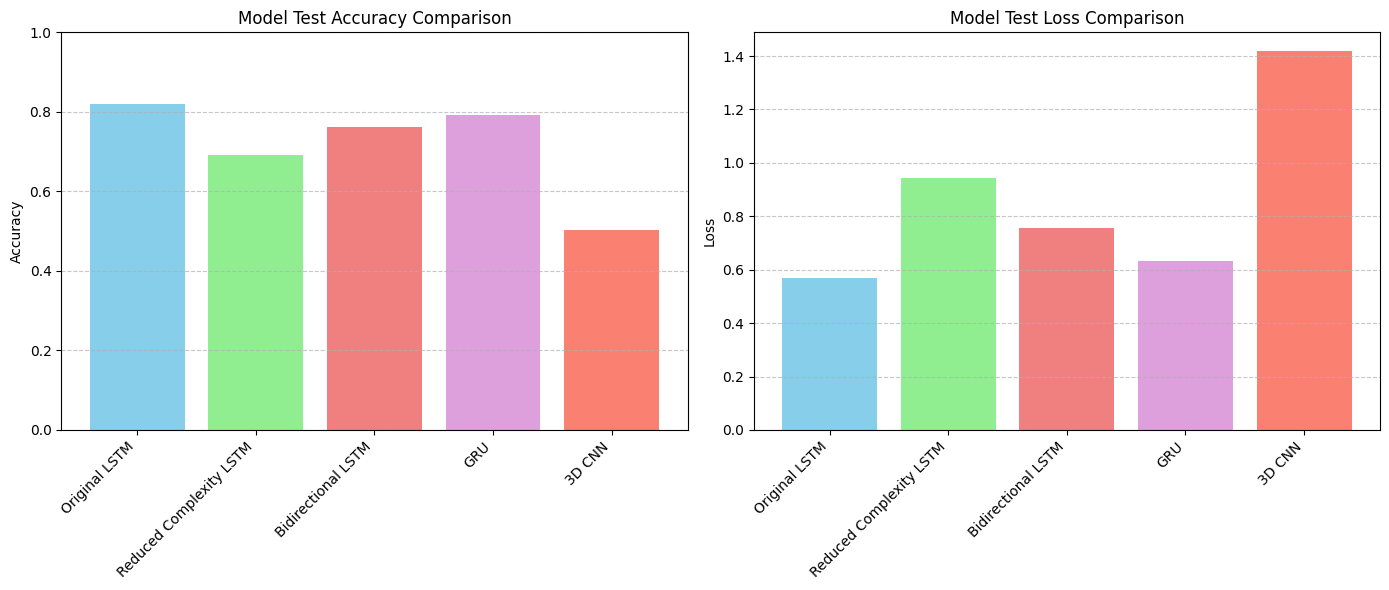

In [63]:

import matplotlib.pyplot as plt

# Plot comparison
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.bar(comparison_df["Model"], comparison_df["Test Accuracy"], color=['skyblue', 'lightgreen', 'lightcoral', 'plum', 'salmon'])
plt.title("Model Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Loss Plot
plt.subplot(1, 2, 2)
plt.bar(comparison_df["Model"], comparison_df["Test Loss"], color=['skyblue', 'lightgreen', 'lightcoral', 'plum', 'salmon'])
plt.title("Model Test Loss Comparison")
plt.ylabel("Loss")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


To systematically evaluate and compare the different deep learning models implemented in this project,  
I plotted their test accuracy and test loss side-by-side.

The following bar charts clearly illustrate how each model performed on the unseen test set:

- **Original LSTM**: The baseline sequential model using standard LSTM layers.
- **Reduced Complexity LSTM**: A lighter version of LSTM with fewer units and higher dropout.
- **Bidirectional LSTM**: An advanced LSTM model that learns from both past and future timesteps.
- **GRU**: Gated Recurrent Unit, a simpler and faster alternative to LSTM.
- **3D CNN**: A convolutional model that treats activity sequences as spatial-temporal volumes.

**Observations:**
- The **Original LSTM** achieved the highest test accuracy.
- The **GRU** model was competitive in accuracy with slightly lower complexity.
- The **3D CNN** model showed lower performance compared to sequential models, suggesting CNNs might not fully capture sequential dependencies in this task.

These insights guide the selection of the most suitable model architecture for human activity recognition using wearable sensor data.